In [1]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MaxAbsScaler
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import BayesianRidge, RidgeCV, Lasso
from sklearn.linear_model import RANSACRegressor, Ridge, LinearRegression
from lazypredict.Supervised import LazyRegressor

In [2]:
# Load the CSV data into a Pandas DataFrame
data = pd.read_csv('AggregatedData.csv')

In [3]:
# Convert 'Transaction Date' to datetime
data['Transaction Date'] = data['Transaction Date'].str.replace('/', '-', regex=True)
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], format='%d-%m-%Y', errors='coerce')

data

,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,Working Day,Holiday Sequence
0,Big Street ATM,2011-01-01,50,20,30,123800,41700,82100,Saturday,H,H,WHH
1,Mount Road ATM,2011-01-01,253,67,186,767900,270900,497000,Saturday,C,H,WHH
2,Airport ATM,2011-01-01,98,56,42,503400,347700,155700,Saturday,C,H,WHH
3,KK Nagar ATM,2011-01-01,265,159,106,945300,532600,412700,Saturday,C,H,WHH
4,Christ College ATM,2011-01-01,74,25,49,287700,148200,139500,Saturday,C,H,WHH
...,...,...,...,...,...,...,...,...,...,...,...,...
11584,Big Street ATM,2017-09-29,137,34,103,468800,146200,322600,FRIDAY,H,H,WHH
11585,Mount Road ATM,2017-09-29,79,27,52,305100,172500,132600,FRIDAY,H,H,WHH
11586,Airport ATM,2017-09-29,117,77,40,709900,576800,133100,FRIDAY,H,H,WHH
11587,KK Nagar ATM,2017-09-29,76,48,28,408700,279900,128800,FRIDAY,H,H,WHH


In [4]:
# Check for NULL values
data.isna().sum()

ATM Name                        0
Transaction Date                0
No Of Withdrawals               0
No Of XYZ Card Withdrawals      0
No Of Other Card Withdrawals    0
Total amount Withdrawn          0
Amount withdrawn XYZ Card       0
Amount withdrawn Other Card     0
Weekday                         0
Festival Religion               0
Working Day                     0
Holiday Sequence                0
dtype: int64

In [5]:
# Display rows with NULL values (if any)
data[data['Transaction Date'].isna() == True]

,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,Working Day,Holiday Sequence


In [6]:
# Extract day of the week to make it a numeric value
data['DayOfWeek'] = data['Transaction Date'].dt.dayofweek

In [7]:
# Group data by 'ATM Name' and 'Transaction Date', and sum the cash flow values
atm_data = data.groupby(['ATM Name', 'Transaction Date']).sum().reset_index()

# Use LabelEncoder for 'Festival Religion' and 'Holiday Sequence' columns
label_encoder = LabelEncoder()
atm_data['Festival Religion'] = label_encoder.fit_transform(atm_data['Festival Religion'])
atm_data['Holiday Sequence'] = label_encoder.fit_transform(atm_data['Holiday Sequence'])

# Preprocess 'Weekday' column to ensure consistent capitalization
atm_data['Weekday'] = atm_data['Weekday'].str.lower().str.capitalize()

# Use get_dummies for 'Weekday' and 'Working Day' columns
dummy_columns = pd.get_dummies(atm_data[['Weekday', 'Working Day']], columns=['Weekday', 'Working Day'])

# Convert boolean columns to integer values (0 and 1)
dummy_columns = dummy_columns.astype(int)

# Concatenate the dummy columns with the original data
atm_data = pd.concat([atm_data, dummy_columns], axis=1)

atm_data['Working Day'] = label_encoder.fit_transform(atm_data['Working Day'])

# Display the data
atm_data

,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,...,DayOfWeek,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Working Day_H,Working Day_W
0,Airport ATM,2011-01-01,98,56,42,503400,347700,155700,Saturday,0,...,5,0,0,1,0,0,0,0,1,0
1,Airport ATM,2011-01-02,67,53,14,268600,213300,55300,Sunday,4,...,6,0,0,0,1,0,0,0,1,0
2,Airport ATM,2011-01-03,109,90,19,603900,501800,102100,Monday,4,...,0,0,1,0,0,0,0,0,0,1
3,Airport ATM,2011-01-04,113,80,33,541600,418400,123200,Tuesday,4,...,1,0,0,0,0,0,1,0,0,1
4,Airport ATM,2011-01-05,100,70,30,530000,424400,105600,Wednesday,4,...,2,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11584,Mount Road ATM,2017-09-25,91,25,66,447400,257600,189800,Monday,4,...,0,0,1,0,0,0,0,0,0,1
11585,Mount Road ATM,2017-09-26,59,19,40,153800,76200,77600,Tuesday,4,...,1,0,0,0,0,0,1,0,0,1
11586,Mount Road ATM,2017-09-27,63,21,42,167100,84700,82400,Wednesday,4,...,2,0,0,0,0,0,0,1,0,1
11587,Mount Road ATM,2017-09-28,87,28,59,317400,164900,152500,Thursday,4,...,3,0,0,0,0,1,0,0,0,1


In [8]:
# Extract the columns that I want to normalize
columns_after_normalize = ['Norm Total amount Withdrawn', 'Norm Amount withdrawn XYZ Card', 'Norm Amount withdrawn Other Card']
columns_to_normalize = ['Total amount Withdrawn', 'Amount withdrawn XYZ Card', 'Amount withdrawn Other Card']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the columns and create new columns with normalized values
atm_data[columns_after_normalize] = scaler.fit_transform(atm_data[columns_to_normalize])
atm_data

,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,...,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Working Day_H,Working Day_W,Norm Total amount Withdrawn,Norm Amount withdrawn XYZ Card,Norm Amount withdrawn Other Card
0,Airport ATM,2011-01-01,98,56,42,503400,347700,155700,Saturday,0,...,1,0,0,0,0,1,0,0.20,0.18,0.11
1,Airport ATM,2011-01-02,67,53,14,268600,213300,55300,Sunday,4,...,0,1,0,0,0,1,0,0.11,0.11,0.04
2,Airport ATM,2011-01-03,109,90,19,603900,501800,102100,Monday,4,...,0,0,0,0,0,0,1,0.24,0.26,0.07
3,Airport ATM,2011-01-04,113,80,33,541600,418400,123200,Tuesday,4,...,0,0,0,1,0,0,1,0.21,0.22,0.08
4,Airport ATM,2011-01-05,100,70,30,530000,424400,105600,Wednesday,4,...,0,0,0,0,1,0,1,0.21,0.22,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11584,Mount Road ATM,2017-09-25,91,25,66,447400,257600,189800,Monday,4,...,0,0,0,0,0,0,1,0.18,0.14,0.13
11585,Mount Road ATM,2017-09-26,59,19,40,153800,76200,77600,Tuesday,4,...,0,0,0,1,0,0,1,0.06,0.04,0.05
11586,Mount Road ATM,2017-09-27,63,21,42,167100,84700,82400,Wednesday,4,...,0,0,0,0,1,0,1,0.07,0.04,0.06
11587,Mount Road ATM,2017-09-28,87,28,59,317400,164900,152500,Thursday,4,...,0,0,1,0,0,0,1,0.12,0.09,0.10


In [9]:
# Copy the data to a new DataFrame and set the index to 'Transaction Date'
atm_data_day = atm_data.copy()
atm_data_day = atm_data.set_index(['Transaction Date'])
atm_data_day.sort_index(inplace=True)
atm_data_day

,ATM Name,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,Working Day,...,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Working Day_H,Working Day_W,Norm Total amount Withdrawn,Norm Amount withdrawn XYZ Card,Norm Amount withdrawn Other Card
Transaction Date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,Airport ATM,98,56,42,503400,347700,155700,Saturday,0,0,...,1,0,0,0,0,1,0,0.20,0.18,0.11
2011-01-01,Christ College ATM,74,25,49,287700,148200,139500,Saturday,0,0,...,1,0,0,0,0,1,0,0.11,0.08,0.09
2011-01-01,Mount Road ATM,253,67,186,767900,270900,497000,Saturday,0,0,...,1,0,0,0,0,1,0,0.30,0.14,0.34
2011-01-01,Big Street ATM,50,20,30,123800,41700,82100,Saturday,1,0,...,1,0,0,0,0,1,0,0.05,0.02,0.06
2011-01-01,KK Nagar ATM,265,159,106,945300,532600,412700,Saturday,0,0,...,1,0,0,0,0,1,0,0.37,0.28,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-29,Christ College ATM,143,61,82,700400,364200,336200,Friday,1,0,...,0,0,0,0,0,1,0,0.27,0.19,0.23
2017-09-29,Big Street ATM,137,34,103,468800,146200,322600,Friday,1,0,...,0,0,0,0,0,1,0,0.18,0.08,0.22
2017-09-29,KK Nagar ATM,76,48,28,408700,279900,128800,Friday,1,0,...,0,0,0,0,0,1,0,0.16,0.15,0.09


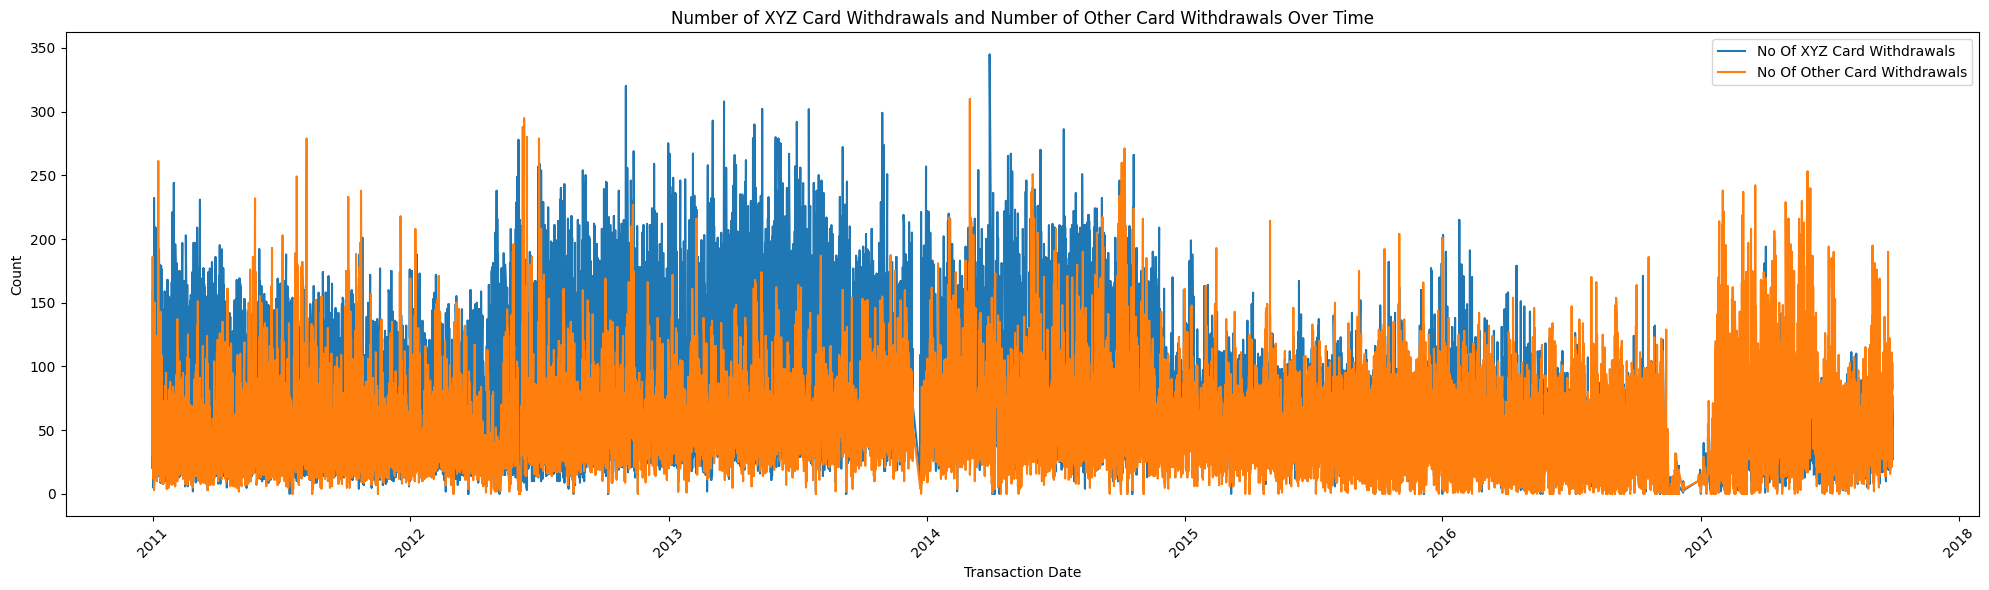

'\n        The line plot provides a visualization of the trends in the number of withdrawals for both XYZ Card \n        and Other Card transactions over time. One notable observation is the big decline in the number of \n        XYZ Card withdrawals and the increase of the Other Card withdrawals compared to XYZ Card withdrawals starting in 2015. \n        This change in transaction volume for both card types suggests a potential shift in customer behavior\n        or external factors affecting ATM usage.\n        \n        From a predictive perspective, those fluctuations in transaction volume can impact the total amount\n        withdrawn for a specific ATM, so those features can be crucial for accurately predicting the future\n        cash flow of ATMs.\n        \n        Incorporating these insights into predictive models can help improve the accuracy of predictions and\n        enable proactive measures to address any challenges posed by changing transaction patterns. Analyzing\n 

In [10]:
# Plotting the No Of XYZ Card Withdrawals and No Of Other Card Withdrawals over time
plt.figure(figsize=(20, 6))
plt.plot(atm_data_day['No Of XYZ Card Withdrawals'], label='No Of XYZ Card Withdrawals')
plt.plot(atm_data_day['No Of Other Card Withdrawals'], label='No Of Other Card Withdrawals')
plt.xlabel('Transaction Date')
plt.ylabel('Count')
plt.title('Number of XYZ Card Withdrawals and Number of Other Card Withdrawals Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

"""
        The line plot provides a visualization of the trends in the number of withdrawals for both XYZ Card 
        and Other Card transactions over time. One notable observation is the big decline in the number of 
        XYZ Card withdrawals and the increase of the Other Card withdrawals compared to XYZ Card withdrawals starting in 2015. 
        This change in transaction volume for both card types suggests a potential shift in customer behavior
        or external factors affecting ATM usage.
        
        From a predictive perspective, those fluctuations in transaction volume can impact the total amount
        withdrawn for a specific ATM, so those features can be crucial for accurately predicting the future
        cash flow of ATMs.
        
        Incorporating these insights into predictive models can help improve the accuracy of predictions and
        enable proactive measures to address any challenges posed by changing transaction patterns. Analyzing
        historical trends and identifying potential drivers behind them is essential for building robust 
        predictive models that capture the complexities of ATM cash flow dynamics.
"""

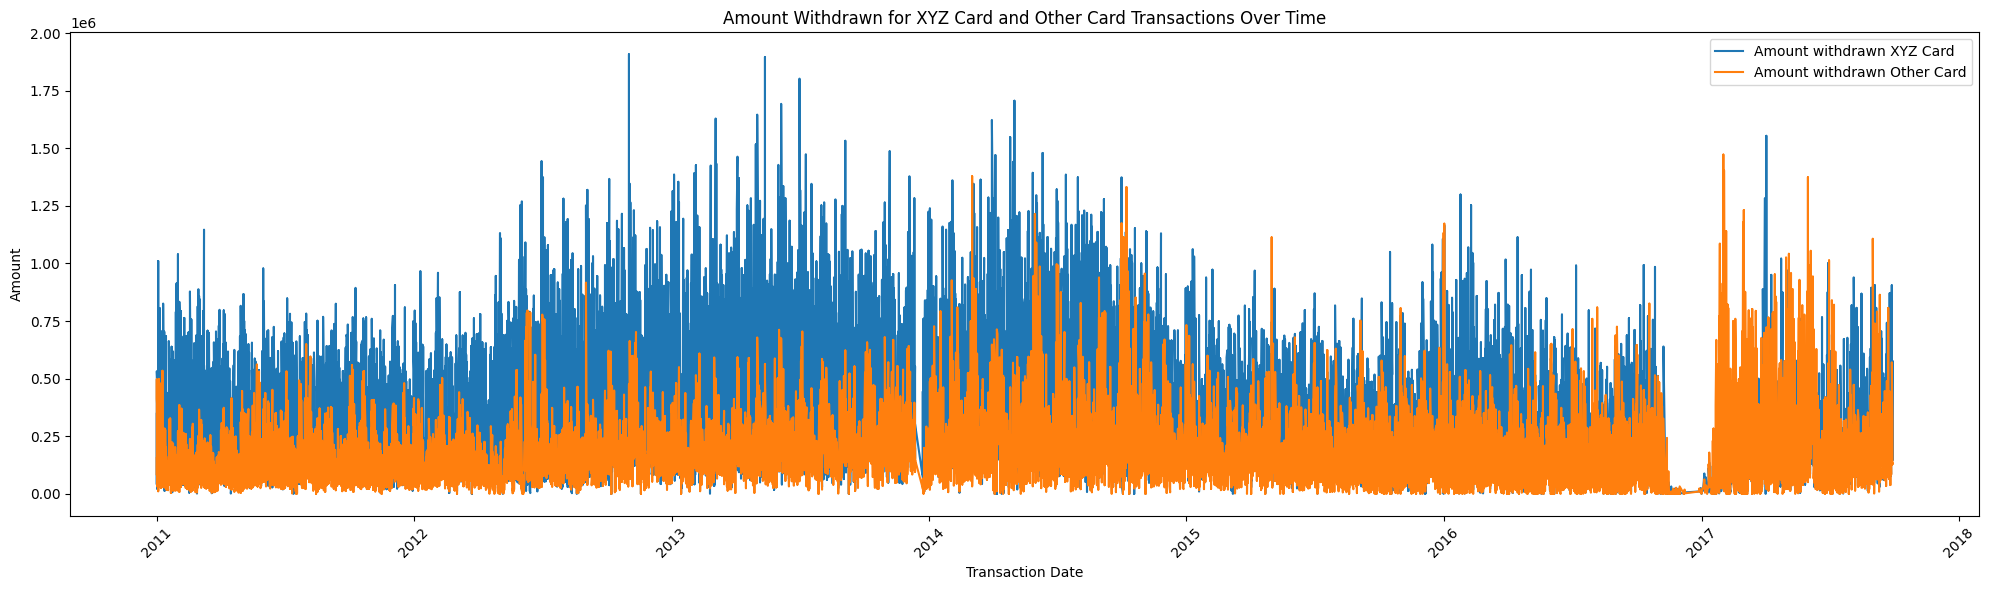

'\n        The line plot provides a clear visualization of the trends in the withdrawn amount for \n        both XYZ Card and Other Card transactions over time. Throughout the depicted time frame,\n        the withdrawn amount for XYZ Card transactions appears to have a more significant \n        presence compared to Other Card transactions. This trend holds except for the start of \n        2017, where the withdrawn amount for Other Card transactions begins to rise, eventually \n        surpassing the amount for XYZ Card transactions.\n\n        This divergence around the beginning of 2017 further underscores the dynamic nature of \n        customer behavior and external factors affecting ATM usage. While the trend may seem \n        aligned for the majority of the period, this shift in the latter part of the timeline \n        highlights the necessity of analyzing comprehensive data, including both transaction \n        volume and withdrawn amounts, to build accurate predictive model

In [11]:
# Creating a Line Plot for XYZ Card and Other Card Withdrawn Amounts Over Time
plt.figure(figsize=(20, 6))
plt.plot(atm_data_day['Amount withdrawn XYZ Card'], label='Amount withdrawn XYZ Card')
plt.plot(atm_data_day['Amount withdrawn Other Card'], label='Amount withdrawn Other Card')
plt.xlabel('Transaction Date')
plt.ylabel('Amount')
plt.title('Amount Withdrawn for XYZ Card and Other Card Transactions Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

"""
        The line plot provides a clear visualization of the trends in the withdrawn amount for 
        both XYZ Card and Other Card transactions over time. Throughout the depicted time frame,
        the withdrawn amount for XYZ Card transactions appears to have a more significant 
        presence compared to Other Card transactions. This trend holds except for the start of 
        2017, where the withdrawn amount for Other Card transactions begins to rise, eventually 
        surpassing the amount for XYZ Card transactions.

        This divergence around the beginning of 2017 further underscores the dynamic nature of 
        customer behavior and external factors affecting ATM usage. While the trend may seem 
        aligned for the majority of the period, this shift in the latter part of the timeline 
        highlights the necessity of analyzing comprehensive data, including both transaction 
        volume and withdrawn amounts, to build accurate predictive models for ATM cash flow. 
        The insights from both transaction volume and withdrawn amounts serve as crucial features 
        for predictive modeling, enabling the development of accurate projections and strategies 
        that respond to changing patterns in ATM usage.
"""


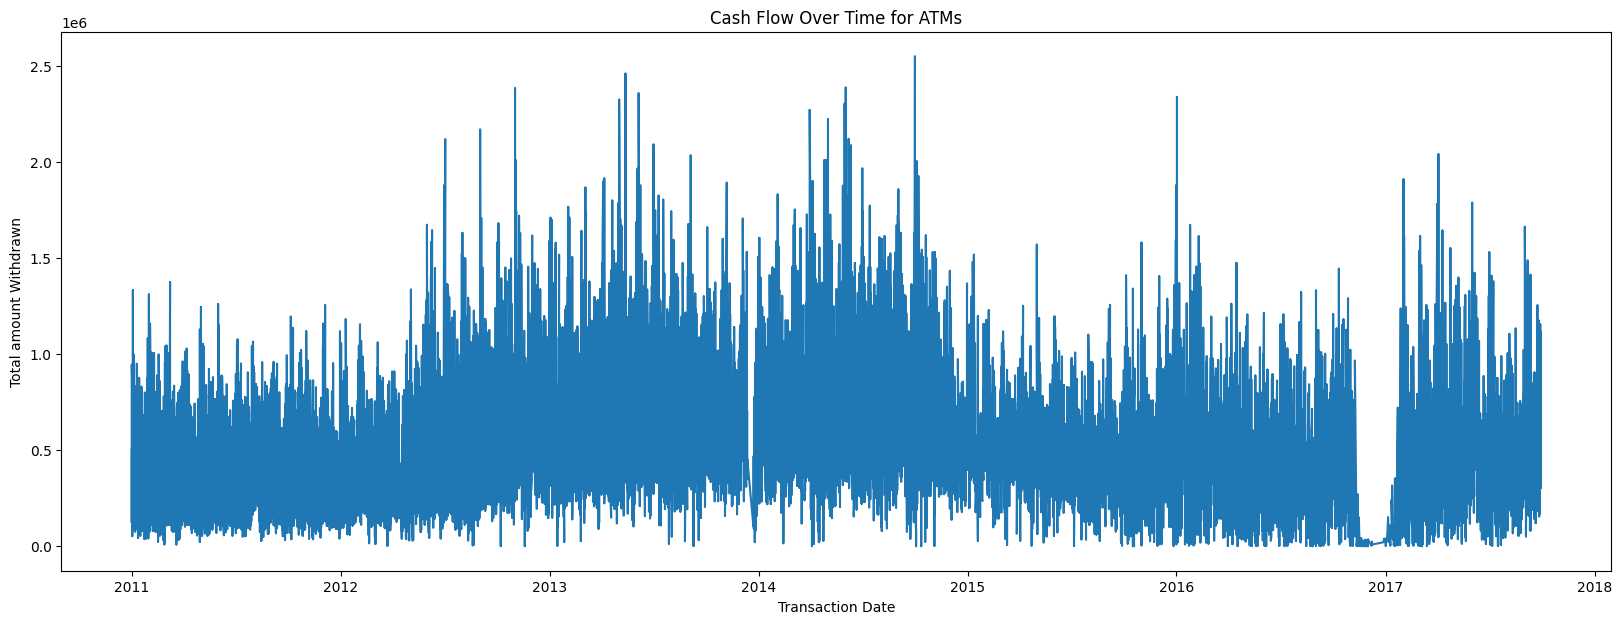

'\n        The line plot visually illustrates the cash flow trends over time for ATMs. \n        The plot showcases that the total amount withdrawn from ATMs exhibits a \n        relatively consistent pattern, with some noticeable deviations. Notably, \n        there is a distinct peak in cash flow observed from around 2013 to 2015, \n        indicating a period of increased ATM usage and withdrawals. However, \n        the preiod just before the start of 2017, there is a visible drop in the \n        cash flow, suggesting a potential shift in customer behavior or external \n        factors affecting cash withdrawal patterns. The overall stability of cash \n        flow, punctuated by these significant variations, highlights the importance \n        of analyzing historical trends and identifying anomalous periods for more \n        accurate prediction and proactive management of ATM cash flow dynamics.\n'

In [12]:
# Creating a Line Plot for Cash Flow Over Time for ATMs
plt.figure(figsize=(20, 7))
plt.plot(atm_data_day['Total amount Withdrawn'])
plt.xlabel('Transaction Date')
plt.ylabel('Total amount Withdrawn')
plt.title('Cash Flow Over Time for ATMs')
plt.show()

"""
        The line plot visually illustrates the cash flow trends over time for ATMs. 
        The plot showcases that the total amount withdrawn from ATMs exhibits a 
        relatively consistent pattern, with some noticeable deviations. Notably, 
        there is a distinct peak in cash flow observed from around 2013 to 2015, 
        indicating a period of increased ATM usage and withdrawals. However, 
        the preiod just before the start of 2017, there is a visible drop in the 
        cash flow, suggesting a potential shift in customer behavior or external 
        factors affecting cash withdrawal patterns. The overall stability of cash 
        flow, punctuated by these significant variations, highlights the importance 
        of analyzing historical trends and identifying anomalous periods for more 
        accurate prediction and proactive management of ATM cash flow dynamics.
"""

In [14]:
# Resample the data to group by month and calculate the sum of transactions
atm_data_monthly = atm_data.copy()
atm_data_monthly['Transaction Date'] = pd.to_datetime(atm_data['Transaction Date']).dt.to_period('M')
atm_data_monthly = atm_data_monthly.groupby(['ATM Name', 'Transaction Date']).sum().reset_index()

# List of columns to drop
columns_to_drop = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'DayOfWeek', 'Norm Total amount Withdrawn', 'Norm Amount withdrawn XYZ Card', 'Norm Amount withdrawn Other Card', 'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Working Day_H', 'Working Day_W']

# Drop the specified columns
atm_data_monthly = atm_data_monthly.drop(columns=columns_to_drop)

# Set 'Transaction Date' as the index
atm_data_monthly.set_index('Transaction Date', inplace=True)

# Normalize the columns and store normalized values in separate columns using MaxAbsScaler
scaler = MaxAbsScaler()
columns_to_normalize = ['Total amount Withdrawn', 'Amount withdrawn XYZ Card', 'Amount withdrawn Other Card']
for column in columns_to_normalize:
    atm_data_monthly[column + '_normalized'] = scaler.fit_transform(atm_data_monthly[[column]])

# Display the resulting dataset with monthly aggregated data and normalized columns
atm_data_monthly


,ATM Name,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Total amount Withdrawn_normalized,Amount withdrawn XYZ Card_normalized,Amount withdrawn Other Card_normalized
Transaction Date,,,,,,,,,,
2011-01,Airport ATM,2755,2022,733,11302600,9225200,2077400,0.28,0.32,0.11
2011-02,Airport ATM,2729,2007,722,11361200,9148600,2212600,0.28,0.31,0.12
2011-03,Airport ATM,3204,2454,750,14078200,11558900,2519300,0.34,0.40,0.13
2011-04,Airport ATM,2625,2012,613,11699600,9608500,2091100,0.29,0.33,0.11
2011-05,Airport ATM,3223,2404,819,13942100,11156600,2785500,0.34,0.38,0.15
...,...,...,...,...,...,...,...,...,...,...
2017-05,Mount Road ATM,2023,736,1287,7458600,4155700,3302900,0.18,0.14,0.18
2017-06,Mount Road ATM,2091,781,1310,6811100,4325700,2485400,0.17,0.15,0.13
2017-07,Mount Road ATM,2094,757,1337,7415700,4162300,3253400,0.18,0.14,0.17


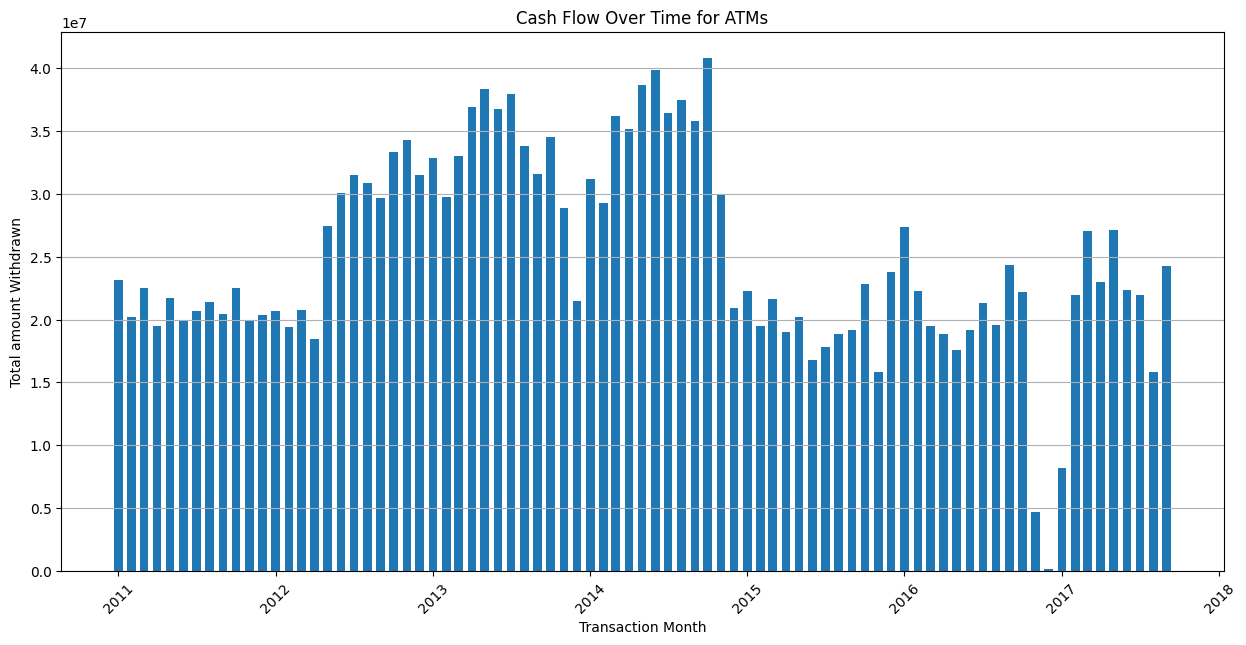

In [15]:
# Plot cash flow over time for all ATMs using bar plot (Monthly)
plt.figure(figsize=(15, 7))
plt.bar(atm_data_monthly.index.to_timestamp(), atm_data_monthly['Total amount Withdrawn'], width=20)
plt.xlabel('Transaction Month')
plt.ylabel('Total amount Withdrawn')
plt.title('Cash Flow Over Time for ATMs')
plt.xticks(rotation=45)
plt.grid(axis='y') 
plt.show()

In [16]:
# Resample the data to group by year and calculate the sum of transactions
atm_data_yearly = atm_data.copy()
atm_data_yearly['Transaction Date'] = pd.to_datetime(atm_data['Transaction Date']).dt.to_period('Y')  # Convert to Period with only year
atm_data_yearly = atm_data_yearly.groupby(['ATM Name', 'Transaction Date']).sum().reset_index()

# List of columns to drop
columns_to_drop = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'DayOfWeek', 'Norm Total amount Withdrawn', 'Norm Amount withdrawn XYZ Card', 'Norm Amount withdrawn Other Card', 'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Working Day_H', 'Working Day_W']

# Drop the specified columns
atm_data_yearly = atm_data_yearly.drop(columns=columns_to_drop)

# Set 'Transaction Date' as the index
atm_data_yearly.set_index('Transaction Date', inplace=True)

# Normalize the columns and store normalized values in separate columns using MaxAbsScaler
scaler = MaxAbsScaler()
columns_to_normalize = ['Total amount Withdrawn', 'Amount withdrawn XYZ Card', 'Amount withdrawn Other Card']
for column in columns_to_normalize:
    atm_data_yearly[column + '_normalized'] = scaler.fit_transform(atm_data_yearly[[column]])

# Display the resulting dataset with yearly aggregated data and normalized columns
atm_data_yearly

,ATM Name,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Total amount Withdrawn_normalized,Amount withdrawn XYZ Card_normalized,Amount withdrawn Other Card_normalized
Transaction Date,,,,,,,,,,
2011,Airport ATM,36603,27536,9067,157992900,130016300,27976600,0.38,0.43,0.19
2012,Airport ATM,38191,28078,10113,180584300,148346800,32237500,0.44,0.49,0.22
2013,Airport ATM,39795,29396,10399,192938600,157525000,35413600,0.47,0.52,0.24
2014,Airport ATM,35205,26597,8608,175293000,147617100,27675900,0.43,0.48,0.19
2015,Airport ATM,29656,22823,6833,156313800,133554500,22759300,0.38,0.44,0.15
2016,Airport ATM,13027,9827,3200,72462000,60868900,11593100,0.18,0.20,0.08
2017,Airport ATM,12232,7974,4258,63926500,49165600,14760900,0.16,0.16,0.10
2011,Big Street ATM,11988,5877,6111,43296300,25074100,18222200,0.11,0.08,0.12
2012,Big Street ATM,21240,8079,13161,75505800,38557600,36948200,0.18,0.13,0.25


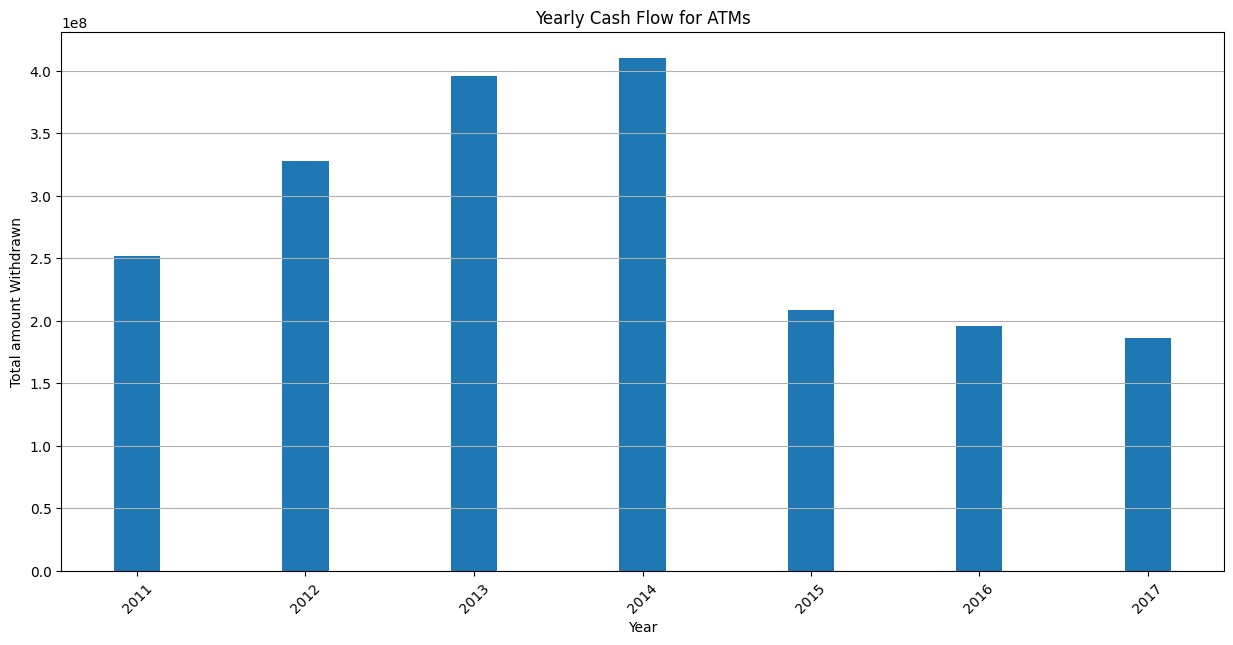

In [17]:
# Plot cash flow over time for all ATMs using bar plot (yearly)
plt.figure(figsize=(15, 7))
plt.bar(atm_data_yearly.index.to_timestamp(), atm_data_yearly['Total amount Withdrawn'], width=100)
plt.xlabel('Year')
plt.ylabel('Total amount Withdrawn')
plt.title('Yearly Cash Flow for ATMs')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [18]:
# Copy the atm_data to atm_data_day to remove all the changes made on atm_data_day
atm_data_day = atm_data.copy()

In [19]:
# Specifying the columns that I want to apply the lag on
lag_columns = ['Total amount Withdrawn', 'Amount withdrawn XYZ Card', 'Amount withdrawn Other Card', 'No Of Withdrawals', 'No Of XYZ Card Withdrawals', 'No Of Other Card Withdrawals']
lag_shift = 1  # the number of rows that will be shifted is 1

# A loop that goes each column and apply a shift by 1 row over each ATM group
for column in lag_columns:
    lag_column_name = f'{column}_lag_{lag_shift}'
    atm_data_day[lag_column_name] = atm_data_day.groupby('ATM Name')[column].shift(lag_shift)

# Specify the lagged columns to drop null values for because we have a row that contain NULL values at the start of each ATM group
lagged_columns_to_drop = [f'{column}_lag_{lag_shift}' for column in lag_columns]
atm_data_day.dropna(subset=lagged_columns_to_drop, inplace=True)

# Display the updated DataFrame with the lagged columns to ensure that it has been applied correctly
atm_data_day.head(1382)


,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,...,Working Day_W,Norm Total amount Withdrawn,Norm Amount withdrawn XYZ Card,Norm Amount withdrawn Other Card,Total amount Withdrawn_lag_1,Amount withdrawn XYZ Card_lag_1,Amount withdrawn Other Card_lag_1,No Of Withdrawals_lag_1,No Of XYZ Card Withdrawals_lag_1,No Of Other Card Withdrawals_lag_1
1,Airport ATM,2011-01-02,67,53,14,268600,213300,55300,Sunday,4,...,0,0.11,0.11,0.04,503400.00,347700.00,155700.00,98.00,56.00,42.00
2,Airport ATM,2011-01-03,109,90,19,603900,501800,102100,Monday,4,...,1,0.24,0.26,0.07,268600.00,213300.00,55300.00,67.00,53.00,14.00
3,Airport ATM,2011-01-04,113,80,33,541600,418400,123200,Tuesday,4,...,1,0.21,0.22,0.08,603900.00,501800.00,102100.00,109.00,90.00,19.00
4,Airport ATM,2011-01-05,100,70,30,530000,424400,105600,Wednesday,4,...,1,0.21,0.22,0.07,541600.00,418400.00,123200.00,113.00,80.00,33.00
5,Airport ATM,2011-01-06,96,73,23,434500,359200,75300,Thursday,4,...,1,0.17,0.19,0.05,530000.00,424400.00,105600.00,100.00,70.00,30.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,Airport ATM,2014-10-31,99,68,31,433700,333800,99900,Friday,4,...,1,0.17,0.17,0.07,443400.00,365000.00,78400.00,97.00,71.00,26.00
1379,Airport ATM,2014-11-01,127,97,30,781400,642400,139000,Saturday,4,...,0,0.31,0.34,0.09,433700.00,333800.00,99900.00,99.00,68.00,31.00
1380,Airport ATM,2014-11-02,87,52,35,469100,312700,156400,Sunday,4,...,0,0.18,0.16,0.11,781400.00,642400.00,139000.00,127.00,97.00,30.00
1381,Airport ATM,2014-11-03,109,86,23,629700,531900,97800,Monday,4,...,1,0.25,0.28,0.07,469100.00,312700.00,156400.00,87.00,52.00,35.00


In [20]:
# Reset the index and remove the old index levels
atm_data_day.reset_index(level=[0], inplace=True)
atm_data_day.drop(columns=['index'],axis=1, inplace=True)

# Display the DataFrame with the new index
atm_data_day.head(1382)

,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,...,Working Day_W,Norm Total amount Withdrawn,Norm Amount withdrawn XYZ Card,Norm Amount withdrawn Other Card,Total amount Withdrawn_lag_1,Amount withdrawn XYZ Card_lag_1,Amount withdrawn Other Card_lag_1,No Of Withdrawals_lag_1,No Of XYZ Card Withdrawals_lag_1,No Of Other Card Withdrawals_lag_1
0,Airport ATM,2011-01-02,67,53,14,268600,213300,55300,Sunday,4,...,0,0.11,0.11,0.04,503400.00,347700.00,155700.00,98.00,56.00,42.00
1,Airport ATM,2011-01-03,109,90,19,603900,501800,102100,Monday,4,...,1,0.24,0.26,0.07,268600.00,213300.00,55300.00,67.00,53.00,14.00
2,Airport ATM,2011-01-04,113,80,33,541600,418400,123200,Tuesday,4,...,1,0.21,0.22,0.08,603900.00,501800.00,102100.00,109.00,90.00,19.00
3,Airport ATM,2011-01-05,100,70,30,530000,424400,105600,Wednesday,4,...,1,0.21,0.22,0.07,541600.00,418400.00,123200.00,113.00,80.00,33.00
4,Airport ATM,2011-01-06,96,73,23,434500,359200,75300,Thursday,4,...,1,0.17,0.19,0.05,530000.00,424400.00,105600.00,100.00,70.00,30.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,Airport ATM,2014-10-31,99,68,31,433700,333800,99900,Friday,4,...,1,0.17,0.17,0.07,443400.00,365000.00,78400.00,97.00,71.00,26.00
1378,Airport ATM,2014-11-01,127,97,30,781400,642400,139000,Saturday,4,...,0,0.31,0.34,0.09,433700.00,333800.00,99900.00,99.00,68.00,31.00
1379,Airport ATM,2014-11-02,87,52,35,469100,312700,156400,Sunday,4,...,0,0.18,0.16,0.11,781400.00,642400.00,139000.00,127.00,97.00,30.00
1380,Airport ATM,2014-11-03,109,86,23,629700,531900,97800,Monday,4,...,1,0.25,0.28,0.07,469100.00,312700.00,156400.00,87.00,52.00,35.00


In [21]:
# Define the columns for which I want to compute the SMA (Simple Moving Average)
columns_to_smooth = ['No Of Withdrawals', 'No Of XYZ Card Withdrawals', 'No Of Other Card Withdrawals', 
                     'Total amount Withdrawn', 'Amount withdrawn XYZ Card', 'Amount withdrawn Other Card']

# Calculate the Simple Moving Average (SMA) with windows of 3, 7, and 10 days
window_size_1 = 3
window_size_2 = 7
window_size_3 = 10

for column in columns_to_smooth:
    # For window size = 3
    # Calculate SMA for each ATM separately
    atm_sma_1 = atm_data_day.groupby('ATM Name')[column].rolling(window=window_size_1, min_periods = 1).mean()
    
    # Reindex the calculated SMA to match the index of atm_data_day
    atm_sma_1 = atm_sma_1.reset_index(level=0, drop=True).reindex(atm_data_day.index)
    
    # Assign the calculated SMA to atm_data_day
    atm_data_day[column + '_SMA_3'] = atm_sma_1
    
    
    # For window size = 7
    # Calculate SMA for each ATM separately
    atm_sma_2 = atm_data_day.groupby('ATM Name')[column].rolling(window=window_size_2, min_periods = 1).mean()
    
    # Reindex the calculated SMA to match the index of atm_data_day
    atm_sma_2 = atm_sma_2.reset_index(level=0, drop=True).reindex(atm_data_day.index)
    
    # Assign the calculated SMA to atm_data_day
    atm_data_day[column + '_SMA_7'] = atm_sma_2
    
    
    # For window size = 10
     # Calculate SMA for each ATM separately
    atm_sma_3 = atm_data_day.groupby('ATM Name')[column].rolling(window=window_size_3, min_periods = 1).mean()
    
    # Reindex the calculated SMA to match the index of atm_data_day
    atm_sma_3 = atm_sma_3.reset_index(level=0, drop=True).reindex(atm_data_day.index)
    
    # Assign the calculated SMA to atm_data_day
    atm_data_day[column + '_SMA_10'] = atm_sma_3


# Display the updated DataFrame with SMA columns to ensure that it has been applied correctly
atm_data_day.head(1382)


,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,...,No Of Other Card Withdrawals_SMA_10,Total amount Withdrawn_SMA_3,Total amount Withdrawn_SMA_7,Total amount Withdrawn_SMA_10,Amount withdrawn XYZ Card_SMA_3,Amount withdrawn XYZ Card_SMA_7,Amount withdrawn XYZ Card_SMA_10,Amount withdrawn Other Card_SMA_3,Amount withdrawn Other Card_SMA_7,Amount withdrawn Other Card_SMA_10
0,Airport ATM,2011-01-02,67,53,14,268600,213300,55300,Sunday,4,...,14.00,268600.00,268600.00,268600.00,213300.00,213300.00,213300.00,55300.00,55300.00,55300.00
1,Airport ATM,2011-01-03,109,90,19,603900,501800,102100,Monday,4,...,16.50,436250.00,436250.00,436250.00,357550.00,357550.00,357550.00,78700.00,78700.00,78700.00
2,Airport ATM,2011-01-04,113,80,33,541600,418400,123200,Tuesday,4,...,22.00,471366.67,471366.67,471366.67,377833.33,377833.33,377833.33,93533.33,93533.33,93533.33
3,Airport ATM,2011-01-05,100,70,30,530000,424400,105600,Wednesday,4,...,24.00,558500.00,486025.00,486025.00,448200.00,389475.00,389475.00,110300.00,96550.00,96550.00
4,Airport ATM,2011-01-06,96,73,23,434500,359200,75300,Thursday,4,...,23.80,502033.33,475720.00,475720.00,400666.67,383420.00,383420.00,101366.67,92300.00,92300.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,Airport ATM,2014-10-31,99,68,31,433700,333800,99900,Friday,4,...,24.50,437700.00,447942.86,387220.00,350333.33,375785.71,319430.00,87366.67,72157.14,67790.00
1378,Airport ATM,2014-11-01,127,97,30,781400,642400,139000,Saturday,4,...,25.70,552833.33,496028.57,455620.00,447066.67,414857.14,377230.00,105766.67,81171.43,78390.00
1379,Airport ATM,2014-11-02,87,52,35,469100,312700,156400,Sunday,4,...,27.40,561400.00,515200.00,469500.00,429633.33,415385.71,383020.00,131766.67,99814.29,86480.00
1380,Airport ATM,2014-11-03,109,86,23,629700,531900,97800,Monday,4,...,27.30,626733.33,544028.57,501580.00,495666.67,440600.00,411750.00,131066.67,103428.57,89830.00


In [22]:
# Define the columns for which you want to compute the EMA (Exponential Moving Average)
columns_to_smooth = ['No Of Withdrawals', 'No Of XYZ Card Withdrawals', 'No Of Other Card Withdrawals', 
                     'Total amount Withdrawn', 'Amount withdrawn XYZ Card', 'Amount withdrawn Other Card']

# Calculate the Exponential Moving Average (EMA) with spans of 10, 30, and 90  days
span_1 = 10
span_2 = 30
span_3 = 90
for column in columns_to_smooth:
    # For span size = 10
    # Calculate EMA for each ATM separately
    atm_ema_1 = atm_data_day.groupby('ATM Name')[column].ewm(span=span_1, min_periods=1).mean()
    
    # Reindex the calculated EMA to match the index of atm_data_day
    atm_ema_1 = atm_ema_1.reset_index(level=0, drop=True).reindex(atm_data_day.index)
    
    # Assign the calculated EMA to atm_data_day
    atm_data_day[column + '_EMA_10'] = atm_ema_1
    
    
    # For span size = 30
    # Calculate EMA for each ATM separately
    atm_ema_2 = atm_data_day.groupby('ATM Name')[column].ewm(span=span_2, min_periods=1).mean()
    
    # Reindex the calculated EMA to match the index of atm_data_day
    atm_ema_2 = atm_ema_2.reset_index(level=0, drop=True).reindex(atm_data_day.index)
    
    # Assign the calculated EMA to atm_data_day
    atm_data_day[column + '_EMA_30'] = atm_ema_2
    
    
    # For span size = 90
    # Calculate EMA for each ATM separately
    atm_ema_3 = atm_data_day.groupby('ATM Name')[column].ewm(span=span_3, min_periods=1).mean()
    
    # Reindex the calculated EMA to match the index of atm_data_day
    atm_ema_3 = atm_ema_3.reset_index(level=0, drop=True).reindex(atm_data_day.index)
    
    # Assign the calculated EMA to atm_data_day
    atm_data_day[column + '_EMA_90'] = atm_ema_3
    

# Display the updated DataFrame with EMA columns to ensure that it has been applied correctly
atm_data_day.head(1382)

,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,...,No Of Other Card Withdrawals_EMA_90,Total amount Withdrawn_EMA_10,Total amount Withdrawn_EMA_30,Total amount Withdrawn_EMA_90,Amount withdrawn XYZ Card_EMA_10,Amount withdrawn XYZ Card_EMA_30,Amount withdrawn XYZ Card_EMA_90,Amount withdrawn Other Card_EMA_10,Amount withdrawn Other Card_EMA_30,Amount withdrawn Other Card_EMA_90
0,Airport ATM,2011-01-02,67,53,14,268600,213300,55300,Sunday,4,...,14.00,268600.00,268600.00,268600.00,213300.00,213300.00,213300.00,55300.00,55300.00,55300.00
1,Airport ATM,2011-01-03,109,90,19,603900,501800,102100,Monday,4,...,16.53,453015.00,441838.33,438112.78,371975.00,362358.33,359152.78,81040.00,79480.00,78960.00
2,Airport ATM,2011-01-04,113,80,33,541600,418400,123200,Tuesday,4,...,22.14,488625.58,477332.95,473377.90,390637.54,382297.63,379342.33,97988.04,95035.32,94035.57
3,Airport ATM,2011-01-05,100,70,30,530000,424400,105600,Wednesday,4,...,24.17,502256.61,491844.64,488008.73,401760.77,393898.37,390984.98,100495.84,97946.27,97023.75
4,Airport ATM,2011-01-06,96,73,23,434500,359200,75300,Thursday,4,...,23.93,482805.53,478797.35,476826.13,389542.73,386003.65,384342.34,93262.80,92793.70,92483.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,Airport ATM,2014-10-31,99,68,31,433700,333800,99900,Friday,4,...,24.67,437329.21,432127.12,453193.57,359670.36,353789.21,373433.55,77658.85,78337.91,79760.02
1378,Airport ATM,2014-11-01,127,97,30,781400,642400,139000,Saturday,4,...,24.79,499887.54,454660.86,460406.90,411075.75,372409.26,379344.90,88811.79,82251.59,81062.00
1379,Airport ATM,2014-11-02,87,52,35,469100,312700,156400,Sunday,4,...,25.01,494289.80,455592.41,460597.96,393189.25,368557.05,377880.18,101100.55,87035.36,82717.78
1380,Airport ATM,2014-11-03,109,86,23,629700,531900,97800,Monday,4,...,24.97,518909.84,466825.16,464314.49,418409.39,379095.31,381265.23,100500.45,87729.85,83049.26


In [23]:
# Reset the index of the DataFrame to default integer index
atm_data_monthly = atm_data_monthly.reset_index()

# Sort the DataFrame by the 'ATM Name' column in ascending order
atm_data_monthly = atm_data_monthly.sort_values(by='ATM Name')

# Sort the DataFrame by the 'Transaction Date' column in ascending order
atm_data_monthly = atm_data_monthly.sort_values(by='Transaction Date')

# Set the index of the DataFrame to a multi-index consisting of 'Transaction Date' and 'ATM Name'
atm_data_monthly = atm_data_monthly.set_index(['Transaction Date', 'ATM Name'])

atm_data_monthly

No Of Withdrawals  \
Transaction Date ATM Name                                
2011-01          Airport ATM                      2755   
                 Big Street ATM                    871   
                 Mount Road ATM                   5318   
                 Christ College ATM               2798   
                 KK Nagar ATM                     6270   
...                                                ...   
2017-09          Christ College ATM               5027   
                 Airport ATM                      2677   
                 Big Street ATM                   3338   
                 KK Nagar ATM                     2916   
                 Mount Road ATM                   2243   

                                     No Of XYZ Card Withdrawals  \
Transaction Date ATM Name                                         
2011-01          Airport ATM                               2022   
                 Big Street ATM                             456   
                 Mount Road ATM                            2292   
                 Christ College ATM                        1204   
                 KK Nagar ATM                              4950   
...                                                         ...   
2017-09          Christ College ATM                        1645   
                 Airport ATM                               1860   
                 Big Street ATM                             895   
                 KK Nagar ATM                              1888   
                 Mount Road ATM                             783   

                                     No Of Other Card Withdrawals  \
Transaction Date ATM Name                                           
2011-01          Airport ATM                                  733   
                 Big Street ATM                               415   
                 Mount Road ATM                              3026   
                 Christ College ATM                          1594   
                 KK Nagar ATM                                1320   
...                                                           ...   
2017-09          Christ College ATM                          3382   
                 Airport ATM                                  817   
                 Big Street ATM                              2443   
                 KK Nagar ATM                                1028   
                 Mount Road ATM                              1460   

                                     Total amount Withdrawn  \
Transaction Date ATM Name                                     
2011-01          Airport ATM                       11302600   
                 Big Street ATM                     2809700   
                 Mount Road ATM                    16167300   
                 Christ College ATM                11402600   
                 KK Nagar ATM                      23137200   
...                                                     ...   
2017-09          Christ College ATM                24300200   
                 Airport ATM                       15230100   
                 Big Street ATM                    12579200   
                 KK Nagar ATM                      19452600   
                 Mount Road ATM                     7633300   

                                     Amount withdrawn XYZ Card  \
Transaction Date ATM Name                                        
2011-01          Airport ATM                           9225200   
                 Big Street ATM                        1635400   
                 Mount Road ATM                        8923100   
                 Christ College ATM                    5836000   
                 KK Nagar ATM                         18839500   
...                                                        ...   
2017-09          Christ College ATM                   10398800   
                 Airport ATM                          12480300   
                 Big Street ATM 

In [24]:
# Reset the index of the DataFrame to default integer index
atm_data_yearly = atm_data_yearly.reset_index()

# Sort the DataFrame by the 'ATM Name' column in ascending order
atm_data_yearly = atm_data_yearly.sort_values(by='ATM Name')

# Sort the DataFrame by the 'Transaction Date' column in ascending order
atm_data_yearly = atm_data_yearly.sort_values(by='Transaction Date')

# Set the index of the DataFrame to a multi-index consisting of 'Transaction Date' and 'ATM Name'
atm_data_yearly = atm_data_yearly.set_index(['Transaction Date', 'ATM Name'])

atm_data_yearly

No Of Withdrawals  \
Transaction Date ATM Name                                
2011             Airport ATM                     36603   
                 Christ College ATM              28486   
                 Big Street ATM                  11988   
                 Mount Road ATM                  63464   
                 KK Nagar ATM                    64051   
2012             Mount Road ATM                  60542   
                 Christ College ATM              34998   
                 KK Nagar ATM                    76946   
                 Big Street ATM                  21240   
                 Airport ATM                     38191   
2013             KK Nagar ATM                    87133   
                 Big Street ATM                  36709   
                 Airport ATM                     39795   
                 Mount Road ATM                  57026   
                 Christ College ATM              44886   
2014             Mount Road ATM                  61885   
                 KK Nagar ATM                    86799   
                 Christ College ATM              56933   
                 Airport ATM                     35205   
                 Big Street ATM                  39149   
2015             Christ College ATM              46236   
                 Airport ATM                     29656   
                 KK Nagar ATM                    36799   
                 Big Street ATM                  41939   
                 Mount Road ATM                  51823   
2016             Airport ATM                     13027   
                 Mount Road ATM                  11375   
                 Big Street ATM                  33936   
                 KK Nagar ATM                    30789   
                 Christ College ATM              40202   
2017             Airport ATM                     12232   
                 KK Nagar ATM                    19341   
                 Christ College ATM              39466   
                 Big Street ATM                  22101   
                 Mount Road ATM                  18449   

                                     No Of XYZ Card Withdrawals  \
Transaction Date ATM Name                                         
2011             Airport ATM                              27536   
                 Christ College ATM                       14486   
                 Big Street ATM                            5877   
                 Mount Road ATM                           27833   
                 KK Nagar ATM                             49524   
2012             Mount Road ATM                           27332   
                 Christ College ATM                       16813   
                 KK Nagar ATM                             56903   
                 Big Street ATM                            8079   
                 Airport ATM                              28078   
2013             KK Nagar ATM                             64607   
                 Big Street ATM                           12042   
                 Airport ATM                              29396   
                 Mount Road ATM                           26640   
                 Christ College ATM                       18813   
2014             Mount Road ATM                           31031   
                 KK Nagar ATM                             58937   
                 Christ College ATM                       19642   
                 Airport ATM                              26597   
                 Big Street ATM                           12656   
2015             Christ College ATM                       19813   
                 Airport ATM                              22823   
                 KK Nagar ATM                             25040   
                 Big Street ATM                           14160   
                 Mount Road ATM                           29139   
2016             Airport ATM                               9827   
              

In [25]:
# Set the Transaction Date as the index for atm_data_day
atm_data_day.set_index('Transaction Date', inplace=True)

In [26]:
atm_data_day.head(2255)

,ATM Name,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,Working Day,...,No Of Other Card Withdrawals_EMA_90,Total amount Withdrawn_EMA_10,Total amount Withdrawn_EMA_30,Total amount Withdrawn_EMA_90,Amount withdrawn XYZ Card_EMA_10,Amount withdrawn XYZ Card_EMA_30,Amount withdrawn XYZ Card_EMA_90,Amount withdrawn Other Card_EMA_10,Amount withdrawn Other Card_EMA_30,Amount withdrawn Other Card_EMA_90
Transaction Date,,,,,,,,,,,,,,,,,,,,,
2011-01-02,Airport ATM,67,53,14,268600,213300,55300,Sunday,4,0,...,14.00,268600.00,268600.00,268600.00,213300.00,213300.00,213300.00,55300.00,55300.00,55300.00
2011-01-03,Airport ATM,109,90,19,603900,501800,102100,Monday,4,1,...,16.53,453015.00,441838.33,438112.78,371975.00,362358.33,359152.78,81040.00,79480.00,78960.00
2011-01-04,Airport ATM,113,80,33,541600,418400,123200,Tuesday,4,1,...,22.14,488625.58,477332.95,473377.90,390637.54,382297.63,379342.33,97988.04,95035.32,94035.57
2011-01-05,Airport ATM,100,70,30,530000,424400,105600,Wednesday,4,1,...,24.17,502256.61,491844.64,488008.73,401760.77,393898.37,390984.98,100495.84,97946.27,97023.75
2011-01-06,Airport ATM,96,73,23,434500,359200,75300,Thursday,4,1,...,23.93,482805.53,478797.35,476826.13,389542.73,386003.65,384342.34,93262.80,92793.70,92483.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-28,Airport ATM,68,47,21,424700,299500,125200,Thursday,4,1,...,25.09,511548.79,509218.85,446363.87,421058.79,418406.37,361286.76,90490.00,90812.48,85077.12
2017-09-29,Airport ATM,117,77,40,709900,576800,133100,Friday,1,0,...,25.41,547612.65,522166.02,452155.88,449375.37,428625.31,366023.31,98237.28,93540.71,86132.57
2011-01-02,Big Street ATM,17,5,12,52800,20900,31900,Sunday,4,0,...,12.00,52800.00,52800.00,52800.00,20900.00,20900.00,20900.00,31900.00,31900.00,31900.00


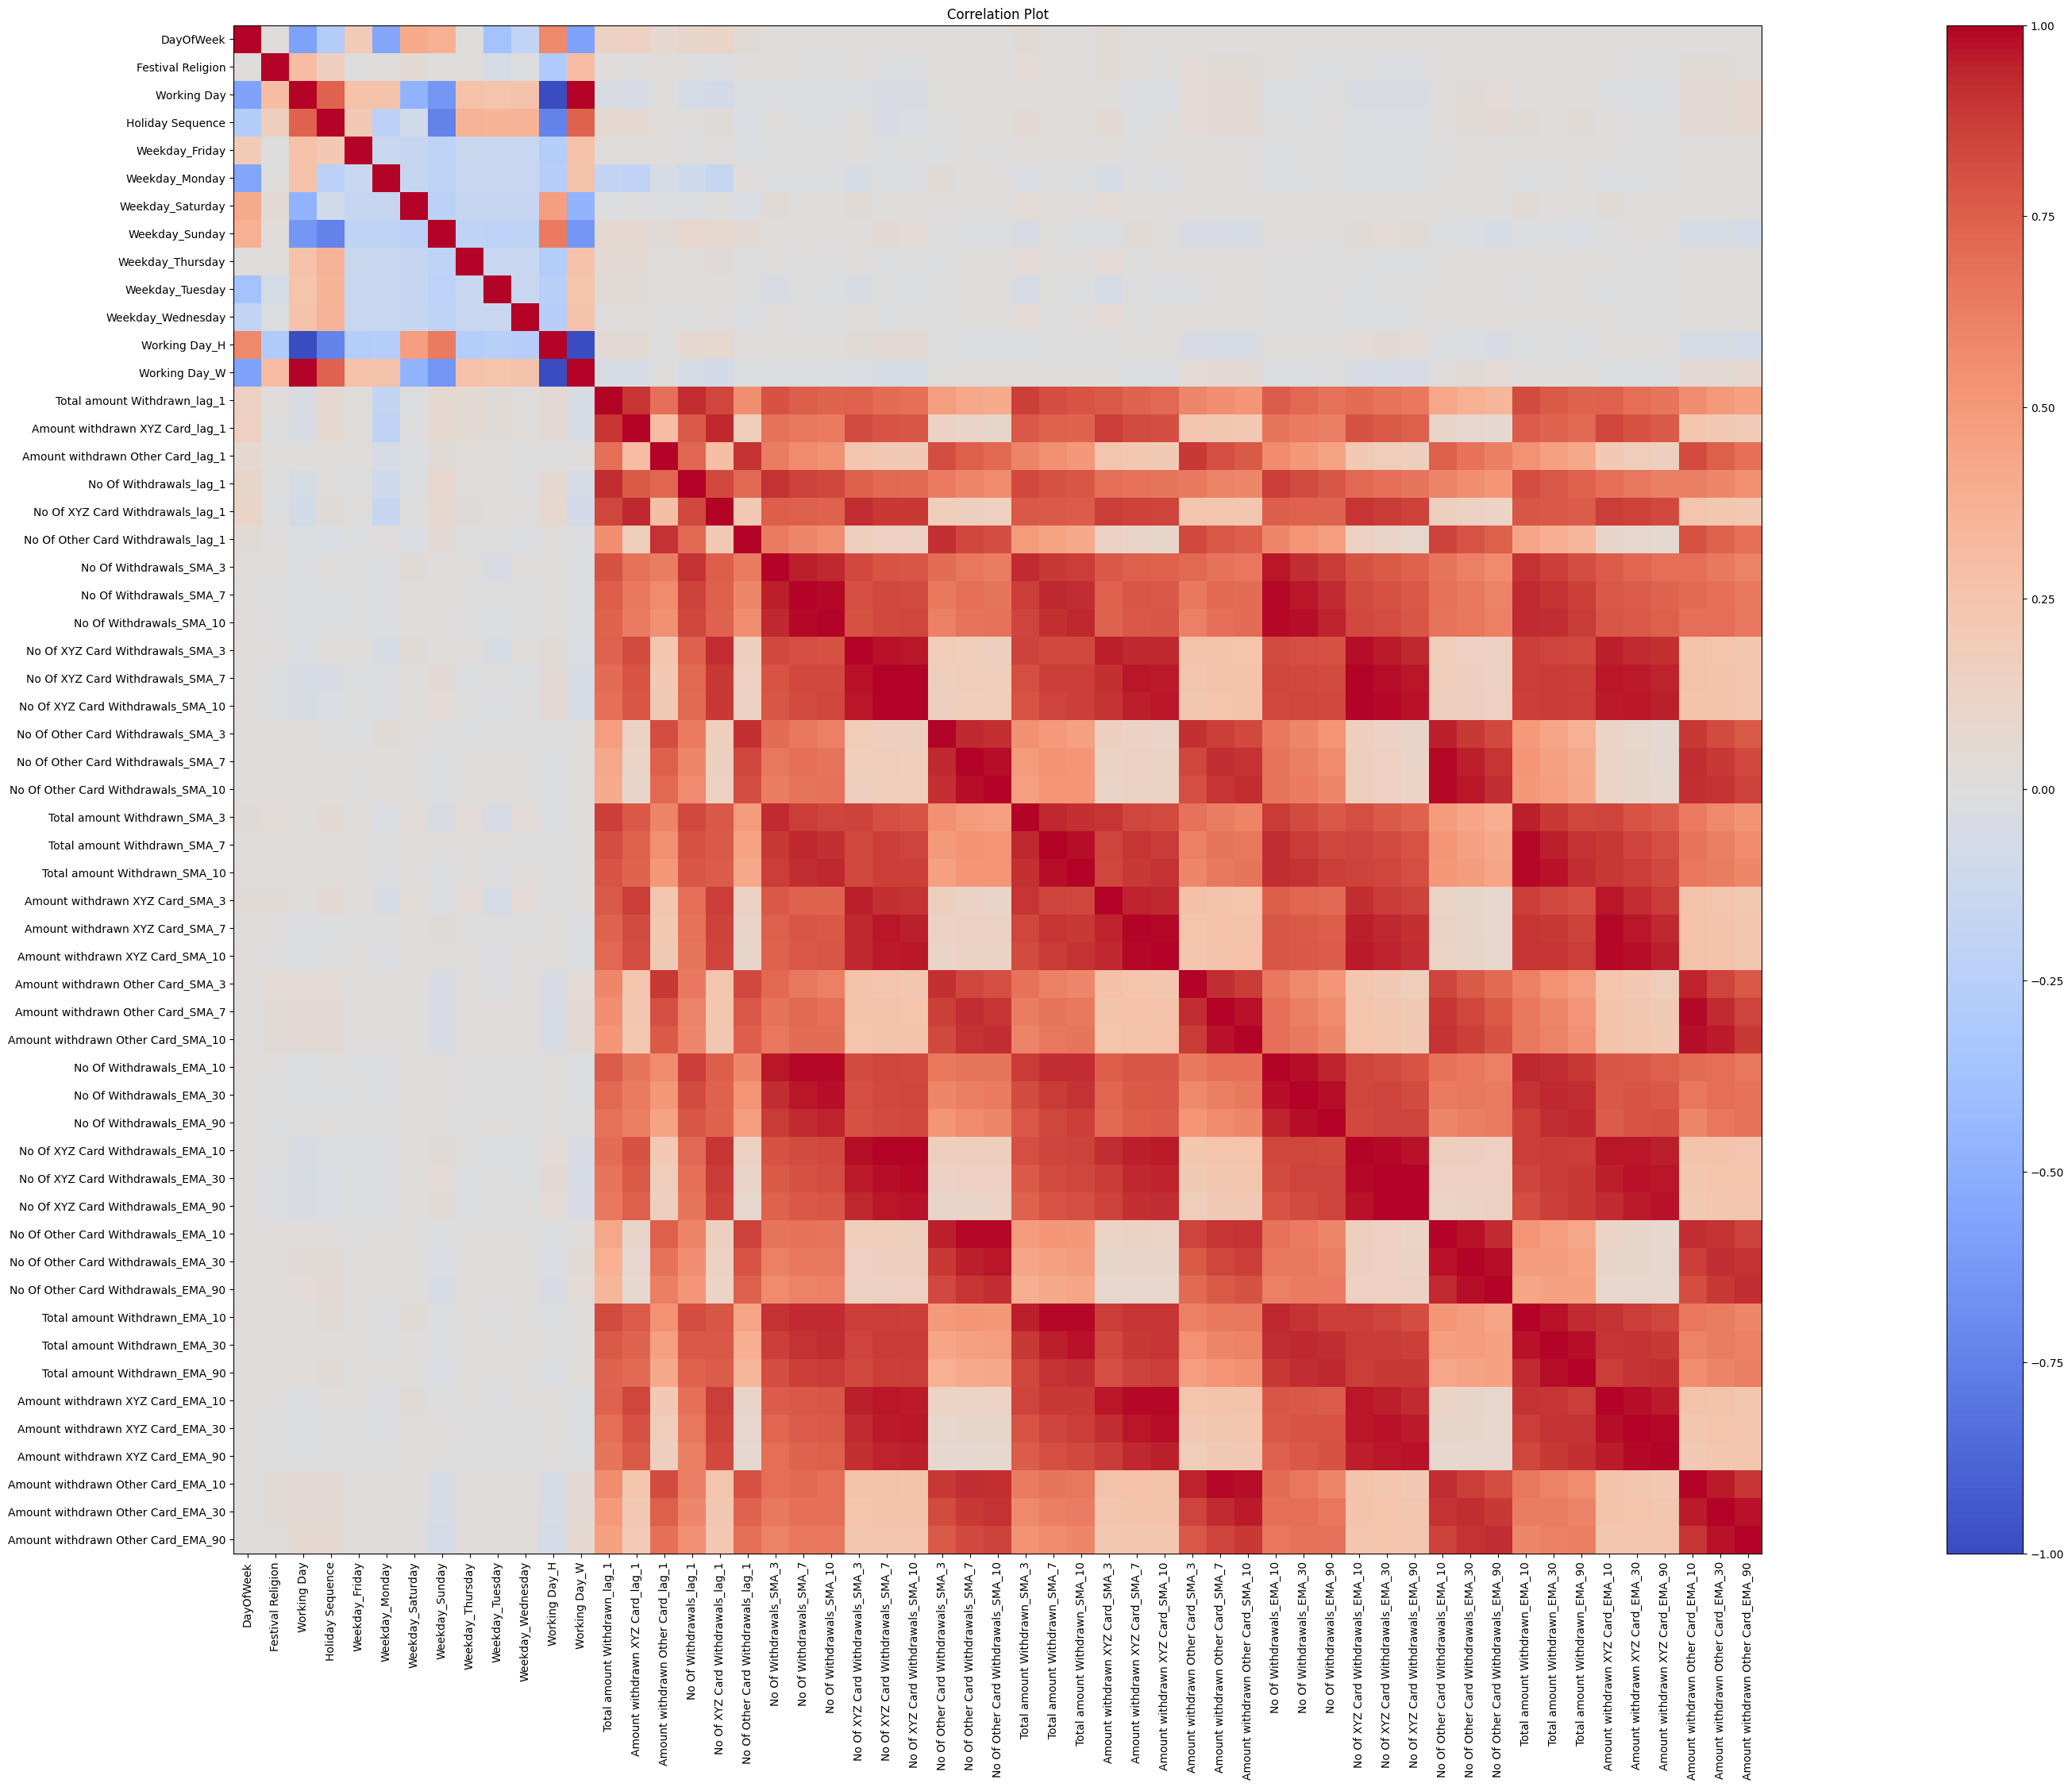

In [27]:
# Select columns for which I want to calculate correlation
selected_columns = ['DayOfWeek', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Weekday_Friday',
       'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday',
       'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday',
       'Working Day_H', 'Working Day_W', 'Total amount Withdrawn_lag_1',
       'Amount withdrawn XYZ Card_lag_1', 'Amount withdrawn Other Card_lag_1',
       'No Of Withdrawals_lag_1', 'No Of XYZ Card Withdrawals_lag_1',
       'No Of Other Card Withdrawals_lag_1', 'No Of Withdrawals_SMA_3',
       'No Of Withdrawals_SMA_7', 'No Of Withdrawals_SMA_10',
       'No Of XYZ Card Withdrawals_SMA_3', 'No Of XYZ Card Withdrawals_SMA_7',
       'No Of XYZ Card Withdrawals_SMA_10',
       'No Of Other Card Withdrawals_SMA_3',
       'No Of Other Card Withdrawals_SMA_7',
       'No Of Other Card Withdrawals_SMA_10', 'Total amount Withdrawn_SMA_3',
       'Total amount Withdrawn_SMA_7', 'Total amount Withdrawn_SMA_10',
       'Amount withdrawn XYZ Card_SMA_3', 'Amount withdrawn XYZ Card_SMA_7',
       'Amount withdrawn XYZ Card_SMA_10', 'Amount withdrawn Other Card_SMA_3',
       'Amount withdrawn Other Card_SMA_7',
       'Amount withdrawn Other Card_SMA_10', 'No Of Withdrawals_EMA_10',
       'No Of Withdrawals_EMA_30', 'No Of Withdrawals_EMA_90',
       'No Of XYZ Card Withdrawals_EMA_10',
       'No Of XYZ Card Withdrawals_EMA_30',
       'No Of XYZ Card Withdrawals_EMA_90',
       'No Of Other Card Withdrawals_EMA_10',
       'No Of Other Card Withdrawals_EMA_30',
       'No Of Other Card Withdrawals_EMA_90', 'Total amount Withdrawn_EMA_10',
       'Total amount Withdrawn_EMA_30', 'Total amount Withdrawn_EMA_90',
       'Amount withdrawn XYZ Card_EMA_10', 'Amount withdrawn XYZ Card_EMA_30',
       'Amount withdrawn XYZ Card_EMA_90',
       'Amount withdrawn Other Card_EMA_10',
       'Amount withdrawn Other Card_EMA_30',
       'Amount withdrawn Other Card_EMA_90']

# Calculate the correlation matrix
correlation_matrix = atm_data_day[selected_columns].corr()

# Create a heatmap-style correlation plot using matplotlib
plt.figure(figsize=(60, 25))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.title('Correlation Plot')
plt.colorbar() 
plt.xticks(range(len(selected_columns)), selected_columns, rotation=90)
plt.yticks(range(len(selected_columns)), selected_columns)
plt.show()

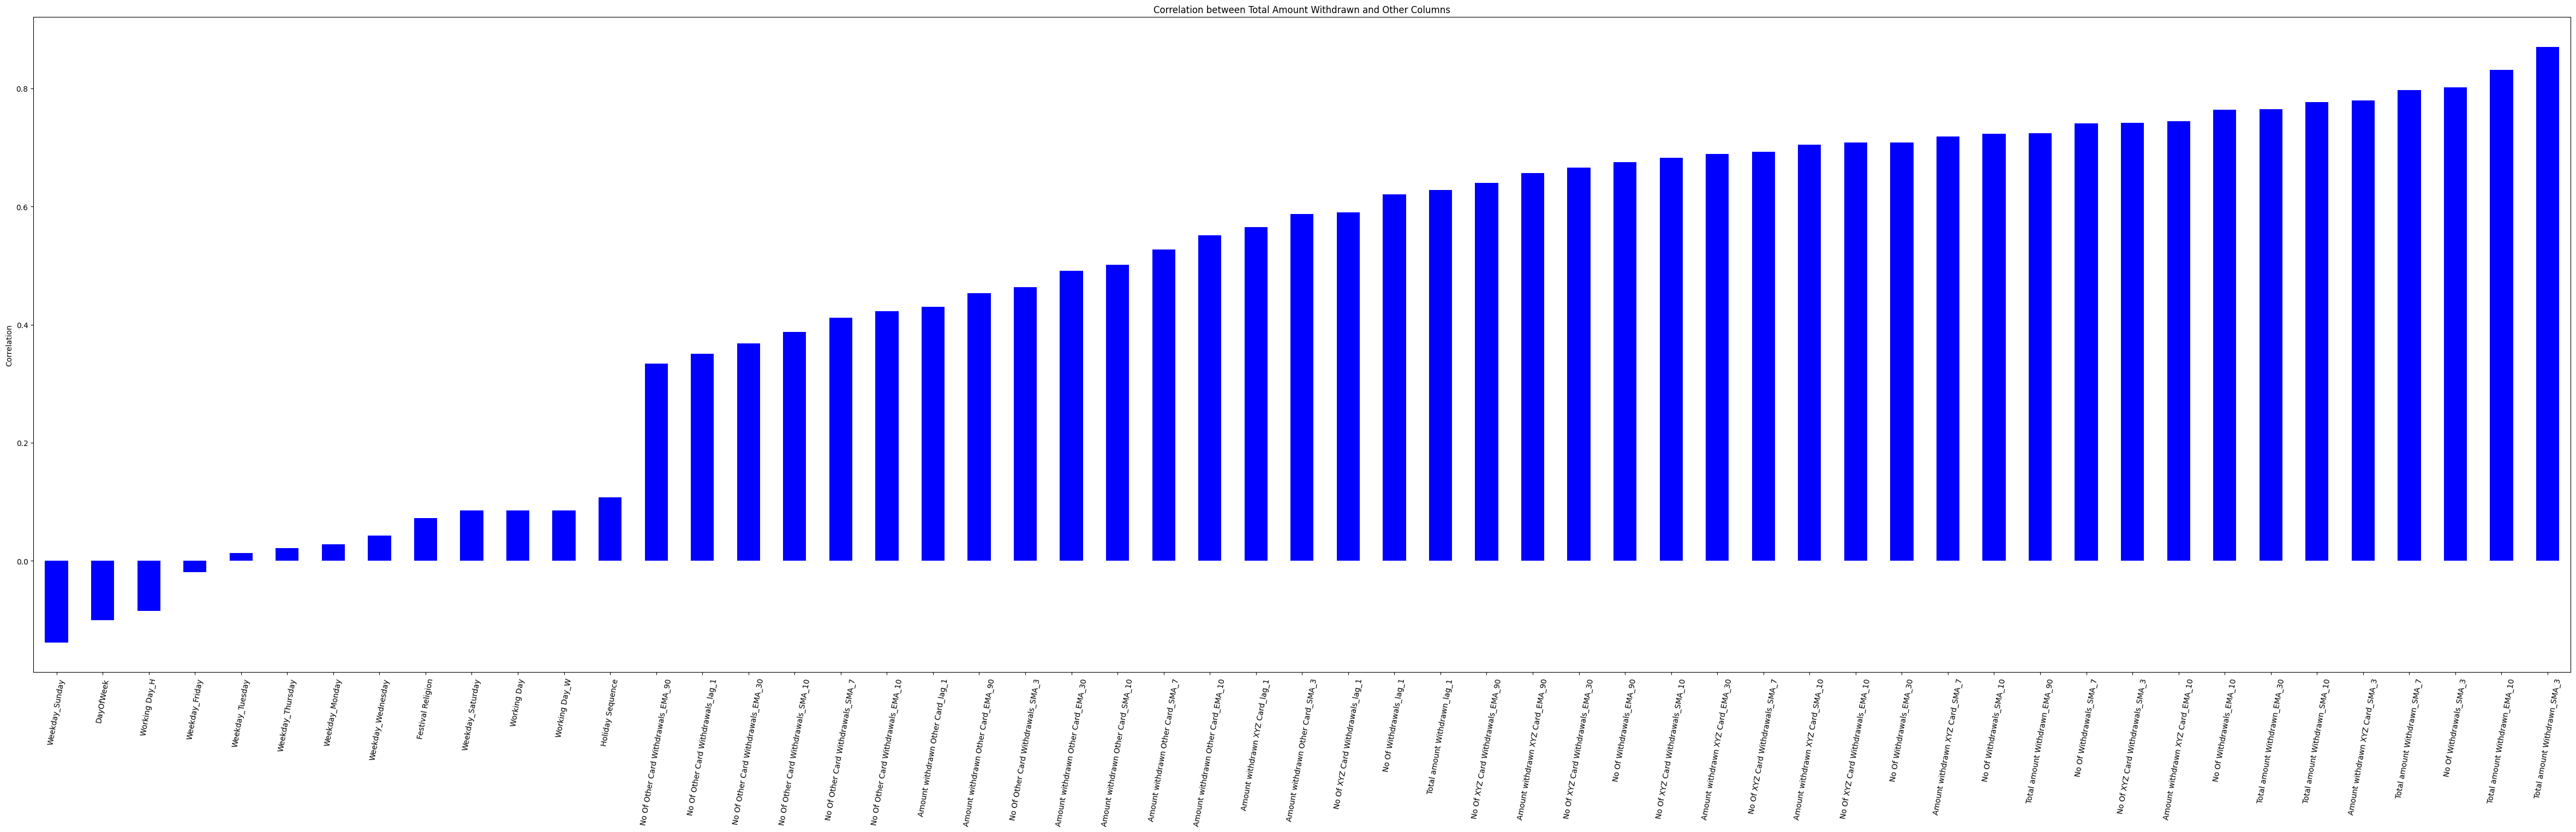

In [28]:
# Calculate the correlation between 'Total amount Withdrawn' and selected columns
correlation_values = atm_data_day[selected_columns].corrwith(atm_data_day['Total amount Withdrawn']).sort_values()

plt.figure(figsize=(60, 25))
correlation_values.plot(kind='bar', color='blue')
plt.title('Correlation between Total Amount Withdrawn and Other Columns')
plt.ylabel('Correlation')

# Increase spacing between labels
plt.subplots_adjust(bottom=0.4)

plt.xticks(rotation=80)
plt.show()

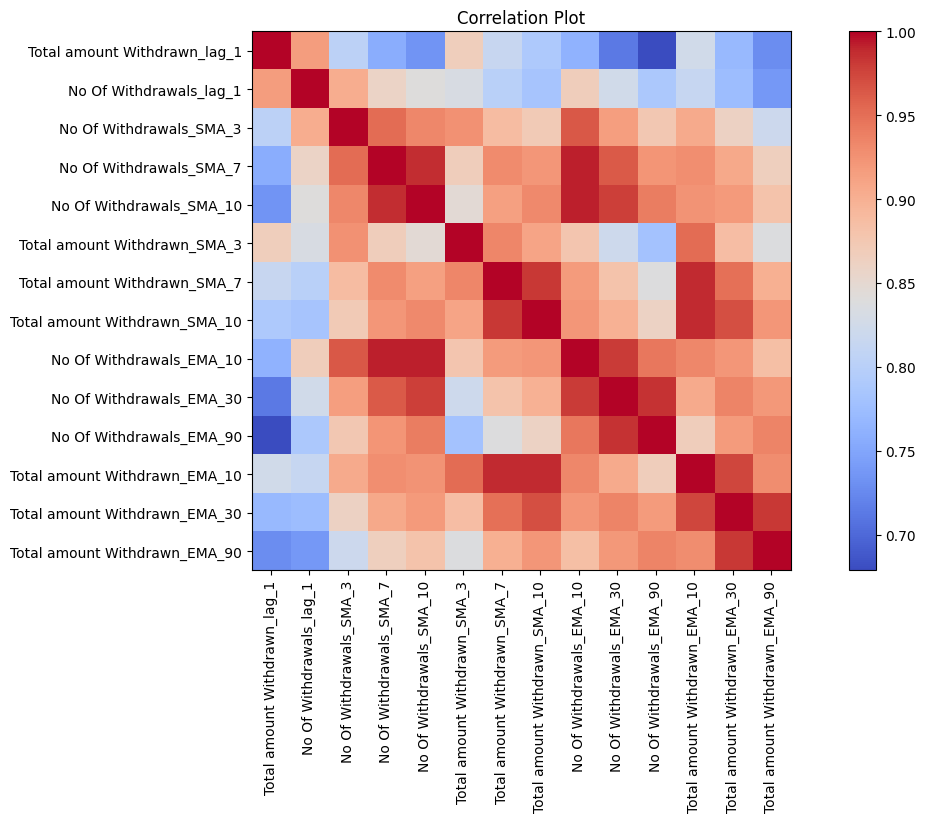

'\n    The presented correlation plot offers valuable insights into the relationships among various \n    features associated with ATM cash flow dynamics. The heatmap-style visualization provides a \n    clear view of the correlation coefficients between different columns representing metrics \n    related to the number of withdrawals and total amount withdrawn for both XYZ Card and Other \n    Card transactions.\n\n    The plot reveals that there is a strong correlation between different time-based moving averages\n    (SMA and EMA) and themselves, indicating the continuity and consistency of trends in withdrawal \n    patterns over time. Moreover, there is a noticeable positive correlation between SMAs and EMAs, \n    suggesting that the smoothed averages of withdrawal metrics align closely, supporting the notion \n    of stable and predictable behavior in cash flow.\n'

In [29]:
# Filter columns that include 'No Of Withdrawals' or 'Total amount Withdrawn' in their names
total_amount_cards_columns_filtered = [col for col in selected_columns if 'No Of Withdrawals' in col or 'Total amount Withdrawn' in col]
# Calculate the correlation matrix
correlation_matrix = atm_data_day[total_amount_cards_columns_filtered].corr()

# Create a heatmap-style correlation plot using matplotlib
plt.figure(figsize=(15, 7))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.title('Correlation Plot')
plt.colorbar()  # Add a colorbar for reference
plt.xticks(range(len(total_amount_cards_columns_filtered)), total_amount_cards_columns_filtered, rotation=90)
plt.yticks(range(len(total_amount_cards_columns_filtered)), total_amount_cards_columns_filtered)
plt.show()

"""
    The presented correlation plot offers valuable insights into the relationships among various 
    features associated with ATM cash flow dynamics. The heatmap-style visualization provides a 
    clear view of the correlation coefficients between different columns representing metrics 
    related to the number of withdrawals and total amount withdrawn for both XYZ Card and Other 
    Card transactions.

    The plot reveals that there is a strong correlation between different time-based moving averages
    (SMA and EMA) and themselves, indicating the continuity and consistency of trends in withdrawal 
    patterns over time. Moreover, there is a noticeable positive correlation between SMAs and EMAs, 
    suggesting that the smoothed averages of withdrawal metrics align closely, supporting the notion 
    of stable and predictable behavior in cash flow.
"""

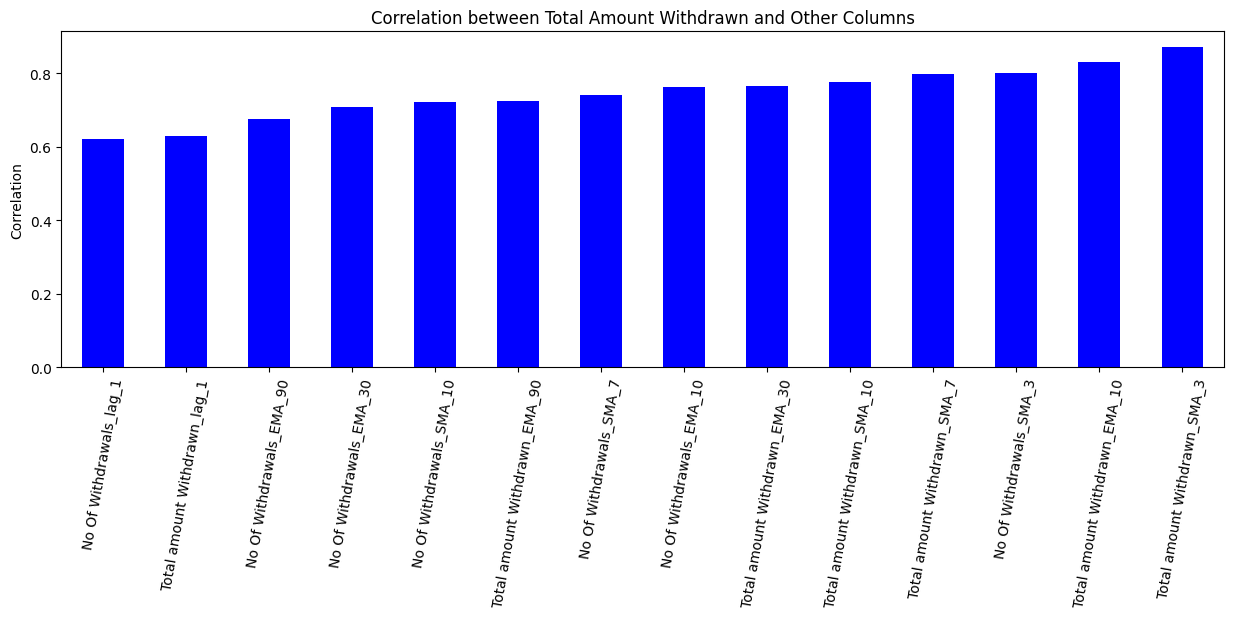

"\n    The presented bar plot not only reveals the strong correlation between the 'Total \n    amount Withdrawn' and various time-based moving averages (SMA and EMA) features but \n    also highlights that the correlation for the lag columns is also noteworthy. While \n    the correlation coefficients for the lag columns may not be as high as those for the \n    smoothed averages, they still indicate a meaningful relationship between historical \n    transaction metrics and the total amount withdrawn from ATMs.\n\n    The positive correlation between the lag columns (e.g., 'Total amount Withdrawn_lag_1', \n    'No Of Withdrawals_lag_1', etc.) and the 'Total amount Withdrawn' suggests that past \n    transaction data holds predictive power for forecasting the future cash flow of ATMs. \n    This finding aligns with the concept that historical transaction behavior can provide \n    insights into the trends and patterns that drive ATM usage and, consequently, the cash flow.\n\n    These i

In [30]:
# Calculate the correlation between 'Total amount Withdrawn' and selected columns
correlation_values = atm_data_day[total_amount_cards_columns_filtered].corrwith(atm_data_day['Total amount Withdrawn']).sort_values()

plt.figure(figsize=(15, 7))
correlation_values.plot(kind='bar', color='blue')
plt.title('Correlation between Total Amount Withdrawn and Other Columns')
plt.ylabel('Correlation')

# Increase spacing between labels
plt.subplots_adjust(bottom=0.4)

plt.xticks(rotation=80)
plt.show()

"""
    The presented bar plot provides valuable insights into the correlations between 
    the target variable, which is the 'Total amount Withdrawn', and various other 
    features related to ATM transactions. The y-axis represents the correlation 
    coefficients, indicating the strength and direction of the relationship.

    The plot highlights a favorable correlation between the 'Total amount Withdrawn' 
    and different time-based moving averages (SMA and EMA) derived from the ATM 
    transaction metrics. The positive correlation indicates that changes in the 
    smoothed averages of transaction metrics, such as 'No Of Withdrawals_SMA_X' 
    and 'No Of Withdrawals_EMA_X', are associated with corresponding changes in 
    the total amount withdrawn from ATMs. This alignment suggests that trends and 
    patterns captured by these features provide valuable predictive insights into 
    the cash flow dynamics of ATMs. Incorporating these features into the model's 
    training can enhance its ability to capture the underlying patterns and 
    fluctuations in ATM transactions, leading to improved predictions and informed 
    decision-making.
"""

"""
    The presented bar plot not only reveals the strong correlation between the 'Total 
    amount Withdrawn' and various time-based moving averages (SMA and EMA) features but 
    also highlights that the correlation for the lag columns is also noteworthy. While 
    the correlation coefficients for the lag columns may not be as high as those for the 
    smoothed averages, they still indicate a meaningful relationship between historical 
    transaction metrics and the total amount withdrawn from ATMs.

    The positive correlation between the lag columns (e.g., 'Total amount Withdrawn_lag_1', 
    'No Of Withdrawals_lag_1', etc.) and the 'Total amount Withdrawn' suggests that past 
    transaction data holds predictive power for forecasting the future cash flow of ATMs. 
    This finding aligns with the concept that historical transaction behavior can provide 
    insights into the trends and patterns that drive ATM usage and, consequently, the cash flow.

    These insights underscore the importance of incorporating a combination of time-related 
    features, including lag columns and moving averages, into predictive models. By doing so, 
    these models can effectively capture both short-term fluctuations and longer-term trends, 
    leading to more accurate and robust predictions of ATM cash flow dynamics.
"""

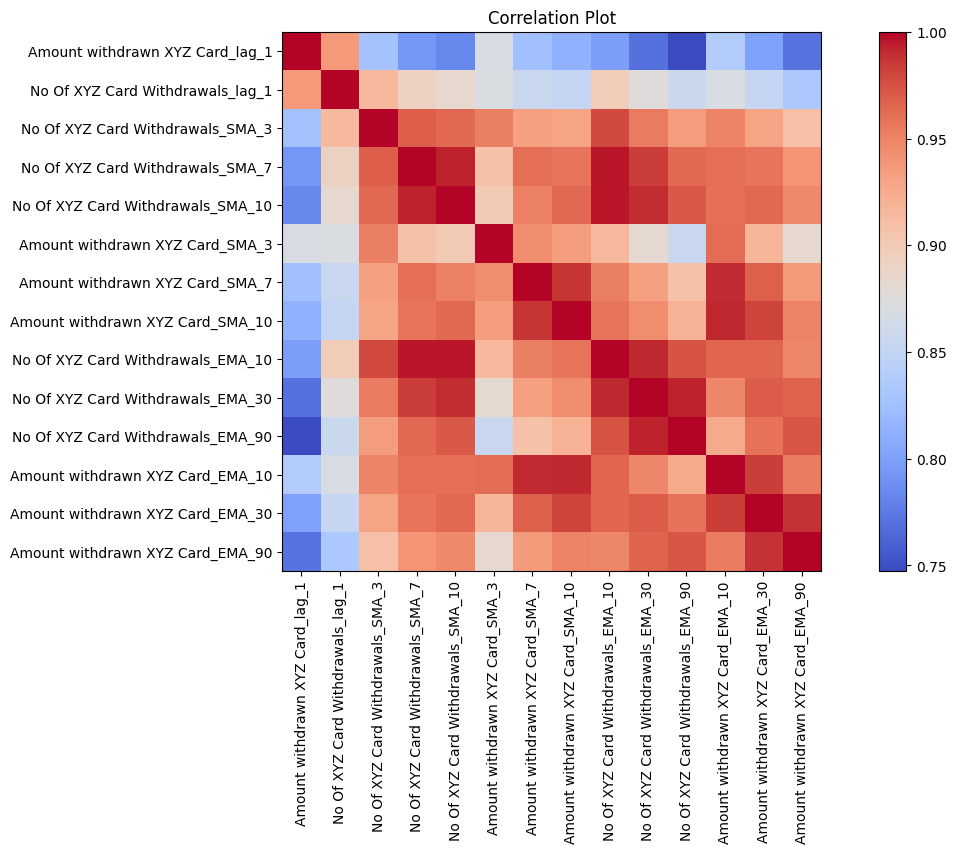

In [31]:
# Filter columns that include 'XYZ'in their names
XYZ_amount_cards_columns_filtered = [col for col in selected_columns if 'XYZ' in col]
# Calculate the correlation matrix
correlation_matrix = atm_data_day[XYZ_amount_cards_columns_filtered].corr()

# Create a heatmap-style correlation plot using matplotlib
plt.figure(figsize=(15, 7))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.title('Correlation Plot')
plt.colorbar()  # Add a colorbar for reference
plt.xticks(range(len(XYZ_amount_cards_columns_filtered)), XYZ_amount_cards_columns_filtered, rotation=90)
plt.yticks(range(len(XYZ_amount_cards_columns_filtered)), XYZ_amount_cards_columns_filtered)
plt.show()

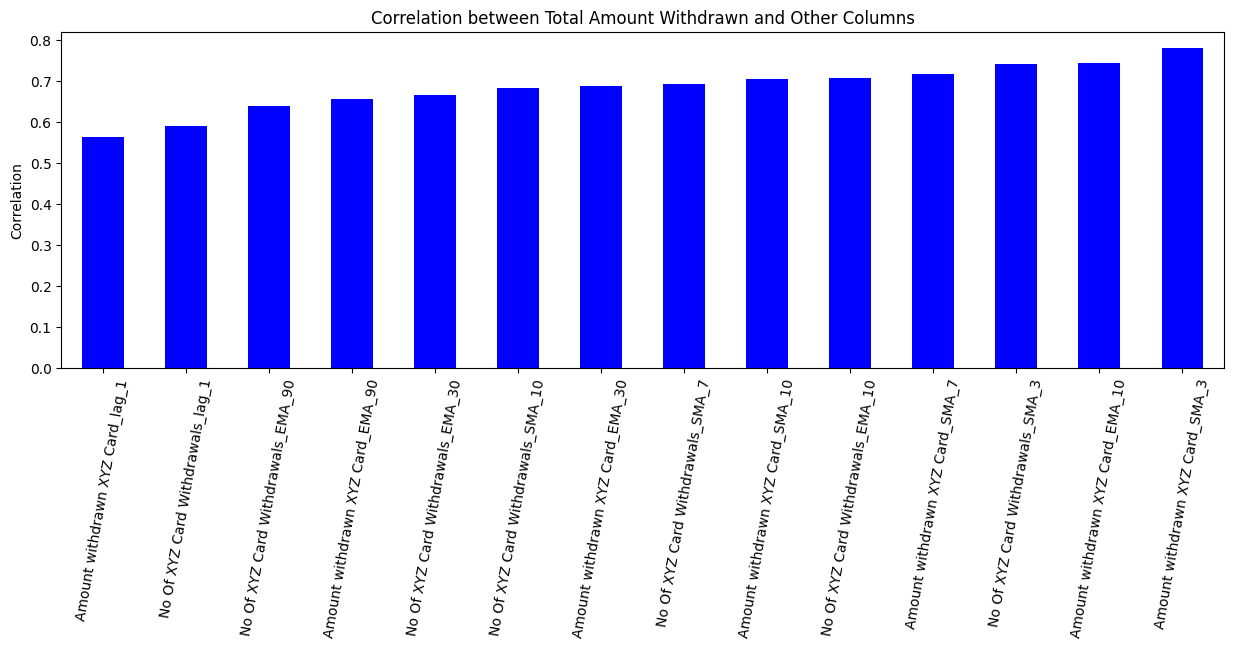

"\n    The generated correlation plots and bar plots, which focus on features related \n    to XYZ Card transactions, echo and reinforce the key insights observed in the \n    previous visualizations. These plots confirm that the correlations between the \n    'Total amount Withdrawn' and various XYZ Card-specific features, such as counts, \n    moving averages, and exponential moving averages, are consistent with the trends \n    identified earlier.\n\n    The high positive correlation between the 'Total amount Withdrawn' and these XYZ\n    Card-related features supports the notion that the transaction behaviors associated \n    with XYZ Card usage have a significant impact on the overall cash flow of ATMs. The \n    strength of these correlations underscores the potential predictive power that these \n    features hold for forecasting future cash flow dynamics.\n\n    Collectively, these analyses emphasize the robustness and reliability of the identified \n    insights. The consisten

In [32]:
# Calculate the correlation between 'Total amount Withdrawn' and selected columns
correlation_values = atm_data_day[XYZ_amount_cards_columns_filtered].corrwith(atm_data_day['Total amount Withdrawn']).sort_values()

plt.figure(figsize=(15, 7))
correlation_values.plot(kind='bar', color='blue')
plt.title('Correlation between Total Amount Withdrawn and Other Columns')
plt.ylabel('Correlation')

# Increase spacing between labels
plt.subplots_adjust(bottom=0.4)

plt.xticks(rotation=80)
plt.show()

"""
    The generated correlation plots and bar plots, which focus on features related 
    to XYZ Card transactions, echo and reinforce the key insights observed in the 
    previous visualizations. These plots confirm that the correlations between the 
    'Total amount Withdrawn' and various XYZ Card-specific features, such as counts, 
    moving averages, and exponential moving averages, are consistent with the trends 
    identified earlier.

    The high positive correlation between the 'Total amount Withdrawn' and these XYZ
    Card-related features supports the notion that the transaction behaviors associated 
    with XYZ Card usage have a significant impact on the overall cash flow of ATMs. The 
    strength of these correlations underscores the potential predictive power that these 
    features hold for forecasting future cash flow dynamics.

    Collectively, these analyses emphasize the robustness and reliability of the identified 
    insights. The consistent patterns observed across different categories of features 
    (including overall transaction counts, counts by card type, moving averages, and exponential 
    moving averages) provide a comprehensive view of the factors influencing ATM cash flow. 
    By leveraging these insights, data-driven predictions can be made more accurate and actionable, 
    facilitating better resource allocation and decision-making within the context of ATM management 
    and operations.

"""

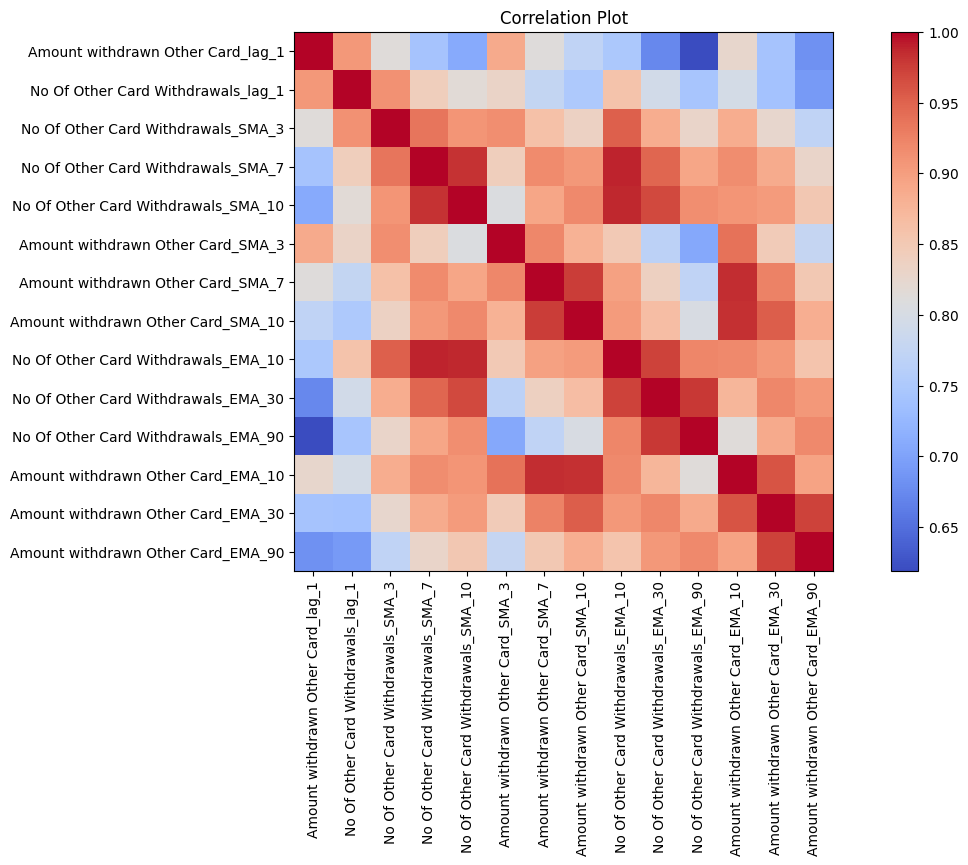

In [33]:
# Filter columns that include 'XYZ'in their names
Other_amount_cards_columns_filtered = [col for col in selected_columns if 'Other' in col]
# Calculate the correlation matrix
correlation_matrix = atm_data_day[Other_amount_cards_columns_filtered].corr()

# Create a heatmap-style correlation plot using matplotlib
plt.figure(figsize=(15, 7))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.title('Correlation Plot')
plt.colorbar()  # Add a colorbar for reference
plt.xticks(range(len(Other_amount_cards_columns_filtered)), Other_amount_cards_columns_filtered, rotation=90)
plt.yticks(range(len(Other_amount_cards_columns_filtered)), Other_amount_cards_columns_filtered)
plt.show()

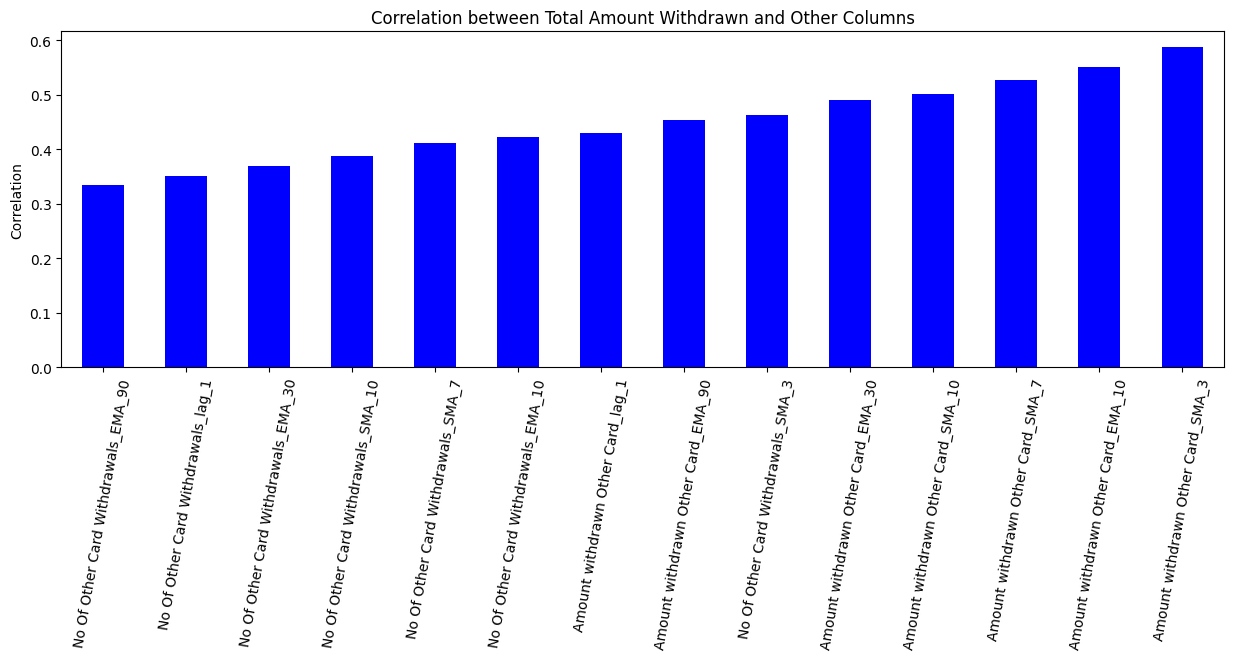

'\n    The correlation plots and bar plots generated for features associated with \n    "Other Card" transactions exhibit a similar pattern of insights as observed \n    in the previous analyses. These visualizations underscore the consistent \n    relationships between different aspects of "Other Card" transaction behavior \n    and the overall cash flow dynamics of ATMs.\n\n    The strong positive correlations observed between the \'Total amount Withdrawn\' \n    and these "Other Card"-related features reinforce the notion that transaction \n    trends linked to "Other Card" usage play a pivotal role in shaping the overall \n    cash flow. This alignment between multiple types of features and their correlations \n    with the target variable emphasizes their predictive potential for forecasting \n    future cash flow patterns accurately.\n\n    The convergence of insights across various categories of features, including \n    transaction counts, moving averages, and exponential movin

In [34]:
# Calculate the correlation between 'Total amount Withdrawn' and selected columns
correlation_values = atm_data_day[Other_amount_cards_columns_filtered].corrwith(atm_data_day['Total amount Withdrawn']).sort_values()

plt.figure(figsize=(15, 7))
correlation_values.plot(kind='bar', color='blue')
plt.title('Correlation between Total Amount Withdrawn and Other Columns')
plt.ylabel('Correlation')

# Increase spacing between labels
plt.subplots_adjust(bottom=0.4)

plt.xticks(rotation=80)
plt.show()

"""
    The correlation plots and bar plots generated for features associated with 
    "Other Card" transactions exhibit a similar pattern of insights as observed 
    in the previous analyses. These visualizations underscore the consistent 
    relationships between different aspects of "Other Card" transaction behavior 
    and the overall cash flow dynamics of ATMs.

    The strong positive correlations observed between the 'Total amount Withdrawn' 
    and these "Other Card"-related features reinforce the notion that transaction 
    trends linked to "Other Card" usage play a pivotal role in shaping the overall 
    cash flow. This alignment between multiple types of features and their correlations 
    with the target variable emphasizes their predictive potential for forecasting 
    future cash flow patterns accurately.

    The convergence of insights across various categories of features, including 
    transaction counts, moving averages, and exponential moving averages for "Other 
    Card" transactions, substantiates the robustness of the conclusions drawn. By 
    considering these insights collectively, data-driven predictions can be enriched 
    with a comprehensive understanding of the drivers behind ATM cash flow dynamics. 
    As a result, decision-makers can make informed choices that optimize the performance 
    and management of ATM networks.
"""

In [35]:
"""
    The next step is to build a predictive model that can accurately forecast the cash flow for each ATM.
"""
atm_data_day.sort_index(inplace=True)
atm_data_day

,ATM Name,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,Working Day,...,No Of Other Card Withdrawals_EMA_90,Total amount Withdrawn_EMA_10,Total amount Withdrawn_EMA_30,Total amount Withdrawn_EMA_90,Amount withdrawn XYZ Card_EMA_10,Amount withdrawn XYZ Card_EMA_30,Amount withdrawn XYZ Card_EMA_90,Amount withdrawn Other Card_EMA_10,Amount withdrawn Other Card_EMA_30,Amount withdrawn Other Card_EMA_90
Transaction Date,,,,,,,,,,,,,,,,,,,,,
2011-01-02,Airport ATM,67,53,14,268600,213300,55300,Sunday,4,0,...,14.00,268600.00,268600.00,268600.00,213300.00,213300.00,213300.00,55300.00,55300.00,55300.00
2011-01-02,Christ College ATM,80,24,56,300000,95600,204400,Sunday,4,0,...,56.00,300000.00,300000.00,300000.00,95600.00,95600.00,95600.00,204400.00,204400.00,204400.00
2011-01-02,Mount Road ATM,194,50,144,529300,171700,357600,Sunday,4,0,...,144.00,529300.00,529300.00,529300.00,171700.00,171700.00,171700.00,357600.00,357600.00,357600.00
2011-01-02,Big Street ATM,17,5,12,52800,20900,31900,Sunday,4,0,...,12.00,52800.00,52800.00,52800.00,20900.00,20900.00,20900.00,31900.00,31900.00,31900.00
2011-01-02,KK Nagar ATM,260,155,105,809400,456200,353200,Sunday,4,0,...,105.00,809400.00,809400.00,809400.00,456200.00,456200.00,456200.00,353200.00,353200.00,353200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-29,Christ College ATM,143,61,82,700400,364200,336200,Friday,1,0,...,102.87,721200.47,738347.76,733101.82,321049.77,326407.72,322834.02,400150.70,411940.04,410267.81
2017-09-29,Big Street ATM,137,34,103,468800,146200,322600,Friday,1,0,...,78.81,448343.07,427625.22,399274.69,192008.09,183802.64,166407.82,256334.98,243822.59,232866.87
2017-09-29,KK Nagar ATM,76,48,28,408700,279900,128800,Friday,1,0,...,31.36,734320.10,659315.75,586028.49,560060.85,495451.33,434461.84,174259.26,163864.42,151566.65


In [36]:
"""
    The features for the input data 'x' have been meticulously selected based 
    on a comprehensive analysis that involves evaluating various graphs and 
    conducting exploratory data analysis (EDA). Additionally, different data 
    selection techniques such as filter, wrapper, and intrinsic methods have 
    been employed to ensure the relevance and significance of the chosen features. 
    This approach aims to enhance the predictive power of the model by incorporating 
    attributes that exhibit meaningful correlations with the target variable 
    'Total amount Withdrawn'.
"""

# Selecting specific columns as features for the input data 'x'

x = atm_data_day[['Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday',
                  'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
                  'Weekday_Wednesday', 'Working Day_H', 'Working Day_W', 'Total amount Withdrawn_lag_1',
                  'Amount withdrawn XYZ Card_lag_1', 'Amount withdrawn Other Card_lag_1',
                  'No Of Withdrawals_lag_1', 'No Of XYZ Card Withdrawals_lag_1',
                  'No Of Other Card Withdrawals_lag_1', 'No Of Withdrawals_SMA_3',
                  'No Of Withdrawals_SMA_7', 'No Of Withdrawals_SMA_10',
                  'No Of XYZ Card Withdrawals_SMA_3', 'No Of XYZ Card Withdrawals_SMA_7',
                  'No Of XYZ Card Withdrawals_SMA_10',
                  'No Of Other Card Withdrawals_SMA_3',
                  'No Of Other Card Withdrawals_SMA_7',
                  'No Of Other Card Withdrawals_SMA_10', 'Total amount Withdrawn_SMA_3',
                  'Total amount Withdrawn_SMA_7', 'Total amount Withdrawn_SMA_10',
                  'Amount withdrawn XYZ Card_SMA_3', 'Amount withdrawn XYZ Card_SMA_7',
                  'Amount withdrawn XYZ Card_SMA_10', 'Amount withdrawn Other Card_SMA_3',
                  'Amount withdrawn Other Card_SMA_7',
                  'Amount withdrawn Other Card_SMA_10', 'No Of Withdrawals_EMA_10',
                  'No Of Withdrawals_EMA_30', 'No Of Withdrawals_EMA_90',
                  'No Of XYZ Card Withdrawals_EMA_10',
                  'No Of XYZ Card Withdrawals_EMA_30',
                  'No Of XYZ Card Withdrawals_EMA_90',
                  'No Of Other Card Withdrawals_EMA_10',
                  'No Of Other Card Withdrawals_EMA_30',
                  'No Of Other Card Withdrawals_EMA_90', 'Total amount Withdrawn_EMA_10',
                  'Total amount Withdrawn_EMA_30', 'Total amount Withdrawn_EMA_90',
                  'Amount withdrawn XYZ Card_EMA_10', 'Amount withdrawn XYZ Card_EMA_30',
                  'Amount withdrawn XYZ Card_EMA_90',
                  'Amount withdrawn Other Card_EMA_10',
                  'Amount withdrawn Other Card_EMA_30',
                  'Amount withdrawn Other Card_EMA_90']]

# Selecting the 'Total amount Withdrawn' column as the target variable 'y'
y = atm_data_day['Total amount Withdrawn']

In [37]:
# Print the length of DataFrame x
print("Length of DataFrame x:", len(x))

# Print the length of DataFrame y
print("Length of DataFrame y:", len(y))

print('\n\n')

# Print the number of missing values in DataFrame x
print("NULL values in DataFrame x:")
print(x.isna().sum())

print('\n\n')

# Print the number of missing values in DataFrame y
print("NULL values in DataFrame y:")
print(y.isna().sum())


Length of DataFrame x: 11584
Length of DataFrame y: 11584



NULL values in DataFrame x:
Weekday_Friday                         0
Weekday_Monday                         0
Weekday_Saturday                       0
Weekday_Sunday                         0
Weekday_Thursday                       0
Weekday_Tuesday                        0
Weekday_Wednesday                      0
Working Day_H                          0
Working Day_W                          0
Total amount Withdrawn_lag_1           0
Amount withdrawn XYZ Card_lag_1        0
Amount withdrawn Other Card_lag_1      0
No Of Withdrawals_lag_1                0
No Of XYZ Card Withdrawals_lag_1       0
No Of Other Card Withdrawals_lag_1     0
No Of Withdrawals_SMA_3                0
No Of Withdrawals_SMA_7                0
No Of Withdrawals_SMA_10               0
No Of XYZ Card Withdrawals_SMA_3       0
No Of XYZ Card Withdrawals_SMA_7       0
No Of XYZ Card Withdrawals_SMA_10      0
No Of Other Card Withdrawals_SMA_3     0
No Of Oth

In [38]:
# Splitting the data into training, validation, and test sets based on date ranges

# Select data up to '2016-01-02' for training
x_train = x[:'2016-01-02']
y_train = y[:'2016-01-02']

# Select data from '2016-01-02' to '2017-01-02' for validation
x_val = x['2016-01-02': '2017-01-02']
y_val = y['2016-01-02': '2017-01-02']

# Select data from '2017-01-02' onwards for testing
x_test = x['2017-01-02':]
y_test = y['2017-01-02':]

# Select data up to '2017-01-02' for K-Fold model
x_kfold = x[:'2017-01-02']
y_kfold = y[:'2017-01-02']

# Select data to '2017-01-02' for time series model
x_time = x[:'2017-01-02']
y_time = y[:'2017-01-02']

In [39]:
# Initialize Lazy Regressor to quickly evaluate multiple models
reg = LazyRegressor()
models_summary = reg.fit(x_train, x_val, y_train, y_val)

# Print the summary report of model performance
print(models_summary)

 98%|█████████▊| 41/42 [04:38<00:08,  8.71s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10681
[LightGBM] [Info] Number of data points in the train set: 8999, number of used features: 51
[LightGBM] [Info] Start training from score 547824.113790


100%|██████████| 42/42 [04:39<00:00,  6.65s/it]

(                                Adjusted R-Squared            R-Squared  \
Model                                                                     
LinearRegression                              0.86                 0.87   
TransformedTargetRegressor                    0.86                 0.87   
BayesianRidge                                 0.86                 0.87   
RidgeCV                                       0.86                 0.87   
Ridge                                         0.86                 0.87   
RANSACRegressor                               0.86                 0.86   
Lasso                                         0.85                 0.86   
SGDRegressor                                  0.85                 0.86   
HuberRegressor                                0.85                 0.86   
LassoCV                                       0.85                 0.86   
PassiveAggressiveRegressor                    0.80                 0.80   
HistGradientBoostingRegr

In [40]:
# Define a list of base models for stacking
base_models = [
    ('Lasso', Lasso()),
    ('BayesianRidge', BayesianRidge()),
    ('RidgeCV', RidgeCV()),
    ('RANSACRegressor', RANSACRegressor()),
    ('ridge', Ridge())
]

# Define a meta-model for stacking
meta_model = LinearRegression()

# Initialize lists to store base model predictions
base_predictions_train = []
base_predictions_val = []

# Loop through each base model
for name, model in base_models:
    model.fit(x_train, y_train)
    train_preds = model.predict(x_train)
    val_preds = model.predict(x_val)
    base_predictions_train.append(train_preds)
    base_predictions_val.append(val_preds)

# Stack the base model predictions horizontally
stacked_train_preds = np.column_stack(base_predictions_train)
stacked_val_preds = np.column_stack(base_predictions_val)

# Fit the meta-model on stacked predictions
meta_model.fit(stacked_train_preds, y_train)

# Predictions using the meta-model on validation and training sets
meta_val_preds = meta_model.predict(stacked_val_preds)
meta_train_preds = meta_model.predict(stacked_train_preds)

# Calculate and print scores and errors for validation and training sets
score_valid = meta_model.score(stacked_val_preds, y_val)
print('Validation Score:', score_valid)

score_train = meta_model.score(stacked_train_preds, y_train)
print('Training Score:', score_train)

mse_valid = mean_squared_error(y_val, meta_val_preds)
print('Validation Mean Squared Error:', mse_valid)

mae_valid = mean_absolute_error(y_val, meta_val_preds)
print('Validation Mean Absolute Error:', mae_valid)

mse_train = mean_squared_error(y_train, meta_train_preds)
print('Training Mean Squared Error:', mse_train)

mae_train = mean_absolute_error(y_train, meta_train_preds)
print('Training Mean Absolute Error:', mae_train)

Validation Score: 0.8669427703930883
Training Score: 0.9200927693113135
Validation Mean Squared Error: 12028739469.364433
Validation Mean Absolute Error: 81712.29259159624
Training Mean Squared Error: 8331399727.804938
Training Mean Absolute Error: 67112.59704065326


Test Score: 0.8565401818293457
Test Mean Squared Error: 16363696863.369862
Test Mean Absolute Error: 94996.08209545167


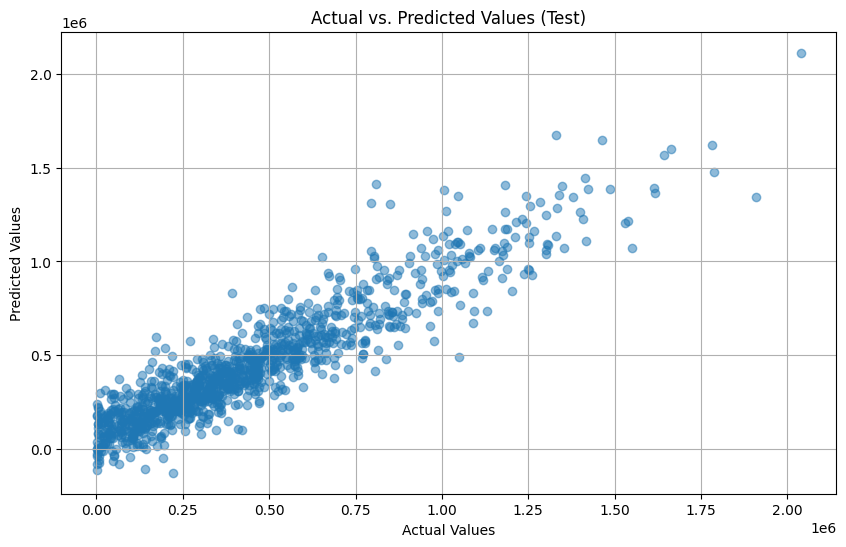

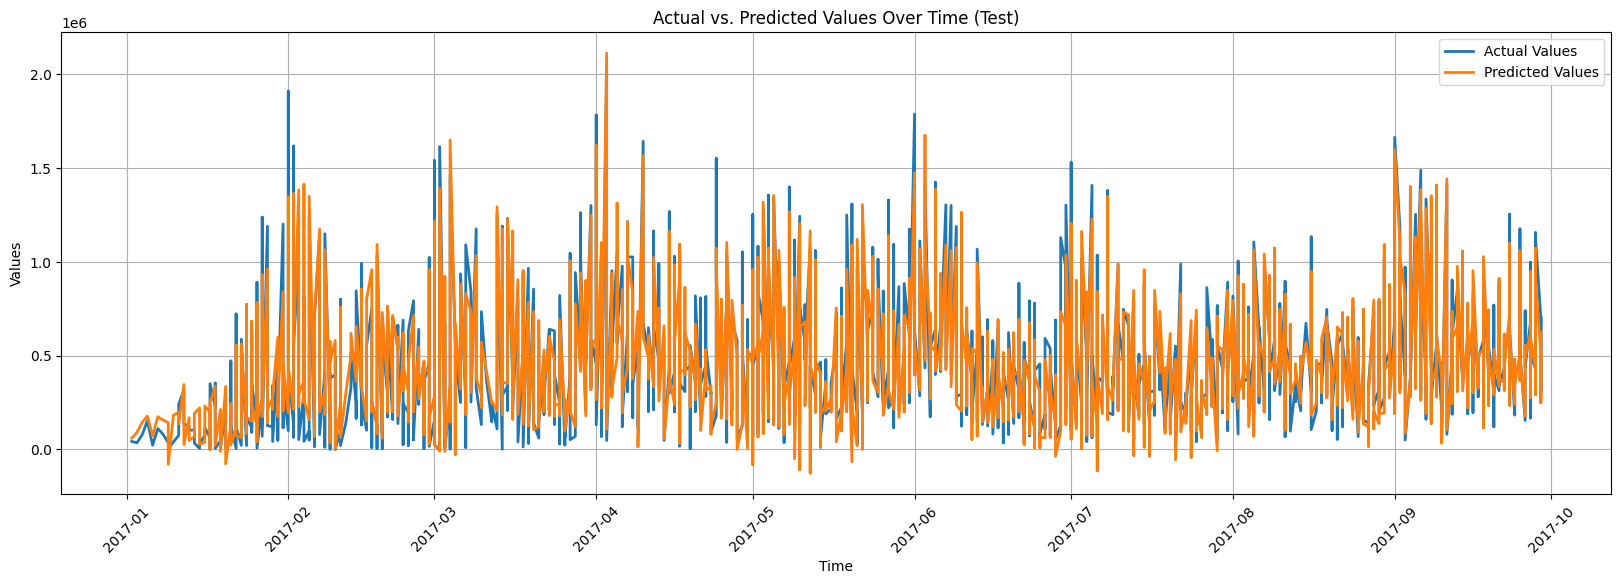

"\n    The close alignment between the validation, training, and test scores indicates \n    consistent performance across different datasets. This consistency is a positive \n    indicator that the model is neither significantly overfitting nor underfitting.\n\n    In conclusion, the stacked ensemble model demonstrates good generalization ability, \n    producing competitive results on both validation and test datasets. This suggests \n    that the ensemble's aggregated predictions from various base models are able to \n    effectively capture the underlying patterns in the data, leading to accurate and \n    reliable predictions on new data points.\n"

In [41]:
# Initialize lists to store base model predictions for the test set
base_predictions_test = []

# Loop through each base model
for name, model in base_models:
    # Train each base model on the full training data (x_train, y_train)
    model.fit(x_train, y_train)
    
    # Make predictions on the test set
    test_preds = model.predict(x_test)
    base_predictions_test.append(test_preds)

# Stack the base model predictions horizontally for the test set
stacked_test_preds = np.column_stack(base_predictions_test)

# Predict using the meta-model on stacked predictions for the test set
meta_test_preds = meta_model.predict(stacked_test_preds)

# Calculate and print scores and errors for the test set
score_test = meta_model.score(stacked_test_preds, y_test)
print('Test Score:', score_test)

mse_test = mean_squared_error(y_test, meta_test_preds)
print('Test Mean Squared Error:', mse_test)

mae_test = mean_absolute_error(y_test, meta_test_preds)
print('Test Mean Absolute Error:', mae_test)

# Create a scatter plot for actual vs. predicted values on the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, meta_test_preds, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Test)')
plt.grid()
plt.show()

# Sort the data by index for visualization
sorted_y_test = y_test.sort_index()
sorted_meta_test_preds = pd.Series(meta_test_preds, index=y_test.index)
sorted_meta_test_preds = sorted_meta_test_preds.sort_index()

# Create a line plot for sorted actual values and sorted predicted values over time
plt.figure(figsize=(20, 6))
plt.plot(sorted_y_test.index, sorted_y_test.values, label='Actual Values', linewidth=2)
plt.plot(sorted_y_test.index, sorted_meta_test_preds, label='Predicted Values', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values Over Time (Test)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

"""
    The close alignment between the validation, training, and test scores indicates 
    consistent performance across different datasets. This consistency is a positive 
    indicator that the model is neither significantly overfitting nor underfitting.

    In conclusion, the stacked ensemble model demonstrates good generalization ability, 
    producing competitive results on both validation and test datasets. This suggests 
    that the ensemble's aggregated predictions from various base models are able to 
    effectively capture the underlying patterns in the data, leading to accurate and 
    reliable predictions on new data points.
"""

Validation Mean Squared Error: 12028887825.164808
Validation Mean Absolute Error: 81713.03461910706
Average Train Score: 0.9200927705087002
Average Validation Score: 0.8669411293390241


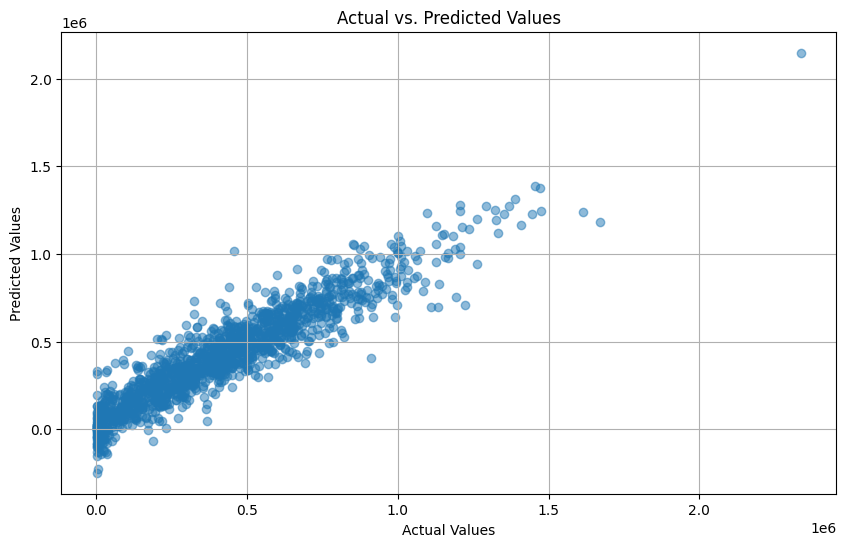

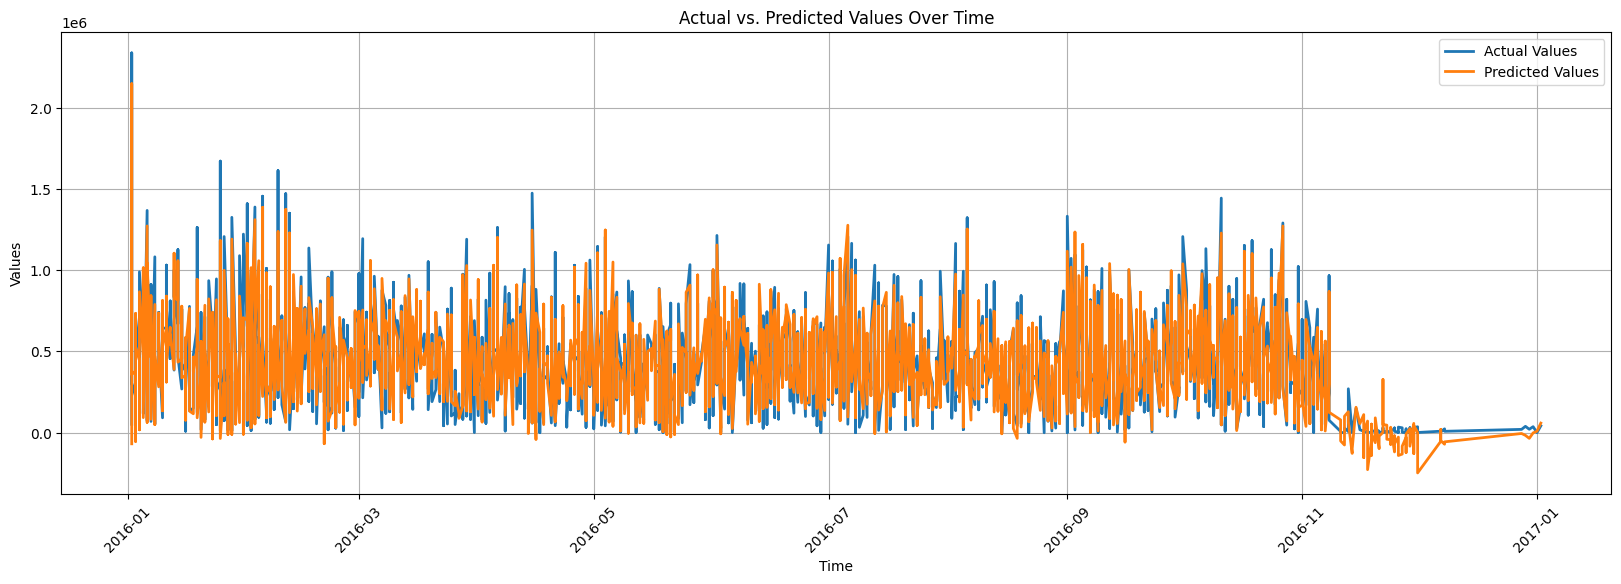

'\n    The relatively close alignment between the average training and \n    validation scores is a positive sign, indicating that the model \n    is likely capturing meaningful patterns and not simply memorizing \n    the training data.\n'

In [42]:
# Train a linear regression model
model_reg = LinearRegression()
model_reg.fit(x_train, y_train)

# Make predictions on the validation set
y_pred_valid = model_reg.predict(x_val)

# Calculate Mean Squared Error for validation set
mse_valid = mean_squared_error(y_val, y_pred_valid)
print('Validation Mean Squared Error:', mse_valid)

# Calculate Mean Absolute Error for validation set
mae_valid = mean_absolute_error(y_val, y_pred_valid)
print('Validation Mean Absolute Error:', mae_valid)

print('Train Score:', model_reg.score(x_train, y_train))
print('Validation Score:', model_reg.score(x_val, y_val))

# Create a scatter plot for actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_valid, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid()
plt.show()

# Sort the data by index
sorted_y_val = y_val.sort_index()
y_pred_valid = pd.Series(y_pred_valid, index=y_val.index)
sorted_y_pred_valid = y_pred_valid.sort_index()

# Create a line plot for sorted actual values and sorted predicted values over time
plt.figure(figsize=(20, 6))
plt.plot(sorted_y_val.index, sorted_y_val.values, label='Actual Values', linewidth=2)
plt.plot(sorted_y_val.index, sorted_y_pred_valid, label='Predicted Values', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()


"""
    The relatively close alignment between the average training and 
    validation scores is a positive sign, indicating that the model 
    is likely capturing meaningful patterns and not simply memorizing 
    the training data.
"""

Test Mean Squared Error: 16363339266.1029
Test Mean Absolute Error: 94995.15465291224
Average Test Score: 0.8565433168690207


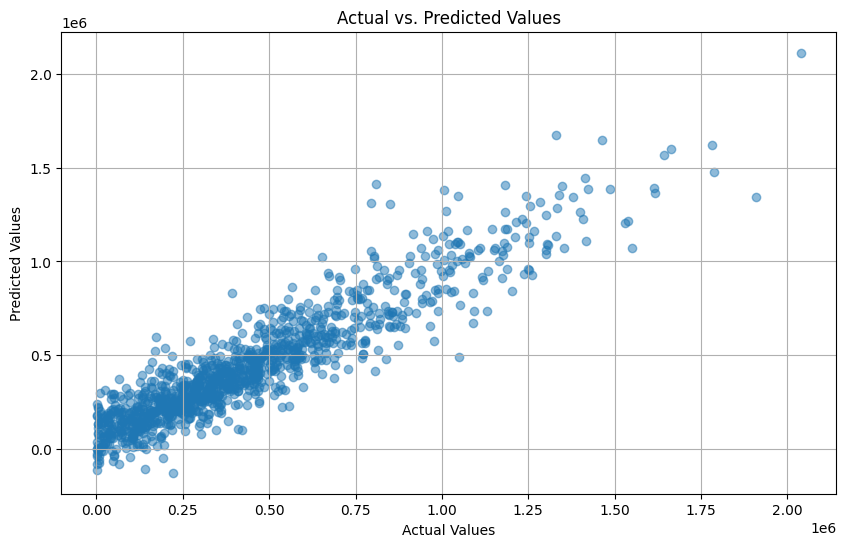

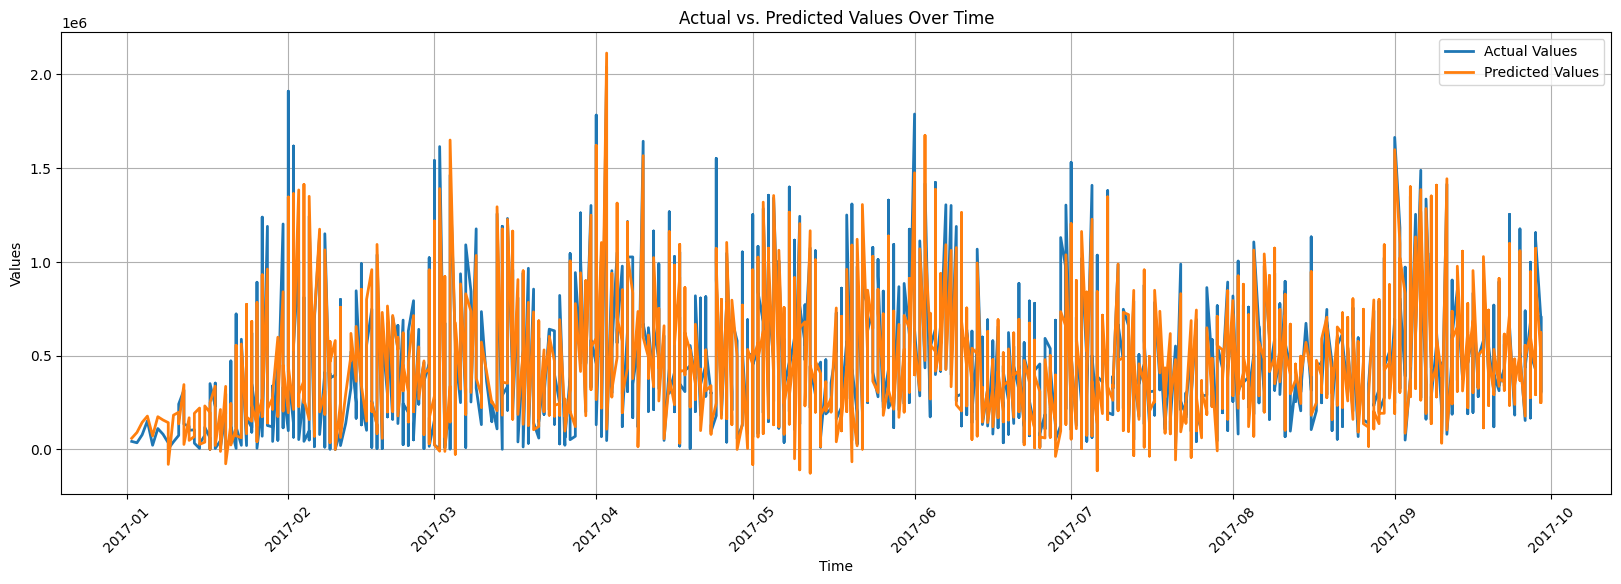

In [43]:
# Test the trained model using the test set
# Make predictions on the test set
y_pred_test = model_reg.predict(x_test)

# Calculate Mean Squared Error for test set
mse_test = mean_squared_error(y_test, y_pred_test)
print('Test Mean Squared Error:', mse_test)

# Calculate Mean Absolute Error for test set
mae_test = mean_absolute_error(y_test, y_pred_test)
print('Test Mean Absolute Error:', mae_test)

# Print average score for the test set
print('Test Score:', model_reg.score(x_test, y_test))

# Create a scatter plot to visualize predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid()
plt.show()

# Sort the data by index for better visualization
sorted_y_test = y_test.sort_index()
y_pred_test = pd.Series(y_pred_test, index=y_test.index)
sorted_y_pred_test = y_pred_test.sort_index()

# Create a line plot to compare sorted actual values and sorted predicted values over time
plt.figure(figsize=(20, 6))
plt.plot(sorted_y_test.index, sorted_y_test.values, label='Actual Values', linewidth=2)
plt.plot(sorted_y_test.index, sorted_y_pred_test, label='Predicted Values', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()


In [44]:
# Initialize and train an XGBoost regressor
xgb_regressor = xgb.XGBRegressor(random_state=42)
xgb_regressor.fit(x_train, y_train)

# Make predictions on the validation set
y_pred_valid = xgb_regressor.predict(x_val)

# Calculate Mean Squared Error for validation set
mse_valid = mean_squared_error(y_val, y_pred_valid)
print('Validation Mean Squared Error:', mse_valid)

# Calculate Mean Absolute Error for validation set
mae_valid = mean_absolute_error(y_val, y_pred_valid)
print('Validation Mean Absolute Error:', mae_valid)

# Calculate R-squared (R2) scores for training and validation sets
r2_train = xgb_regressor.score(x_train, y_train)
r2_valid = xgb_regressor.score(x_val, y_val)
print('Average Train Score:', r2_train)
print('Average Validation Score:', r2_valid)


"""
    Given the difference between the training and validation scores, 
    there exists some level of overfitting, where the model performs 
    exceptionally well on the training data but relatively less well on 
    unseen validation data.
"""

Validation Mean Squared Error: 19788832036.5083
Validation Mean Absolute Error: 103880.3380195809
Average Train Score: 0.9809606758533193
Average Validation Score: 0.7811036497514716


'\n    Given the difference between the training and validation scores, \n    there exists some level of overfitting, where the model performs \n    exceptionally well on the training data but relatively less well on \n    unseen validation data.\n'

In [45]:
# Initialize k-fold cross-validation with 5 splits, shuffling, and a fixed random state
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
mse_scores = []
mae_scores = []
train_scores = []
val_scores = []

# Perform k-fold cross-validation
for train_idx, val_idx in kfold.split(x_kfold):
    # Split the data into training and validation sets based on fold indices
    x_train, x_val = x_kfold.iloc[train_idx], x_kfold.iloc[val_idx]
    y_train, y_val = y_kfold.iloc[train_idx], y_kfold.iloc[val_idx]
    
    # Train a linear regression model on the training data
    KF_linear_model = LinearRegression()
    KF_linear_model.fit(x_train, y_train)
    
    # Make predictions on the validation set
    y_pred_val = KF_linear_model.predict(x_val)
    
    # Calculate evaluation metrics for this fold
    mse = mean_squared_error(y_val, y_pred_val)
    mae = mean_absolute_error(y_val, y_pred_val)
    train_score = KF_linear_model.score(x_train, y_train)
    val_score = KF_linear_model.score(x_val, y_val)
    
    # Append metrics to respective lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    train_scores.append(train_score)
    val_scores.append(val_score)

# Calculate and print the average metrics over all folds
avg_mse = sum(mse_scores) / len(mse_scores)
avg_mae = sum(mae_scores) / len(mae_scores)
avg_train_score = sum(train_scores) / len(train_scores)
avg_val_score = sum(val_scores) / len(val_scores)

print('Average MSE:', avg_mse)
print('Average MAE:', avg_mae)
print('Average Train Score:', avg_train_score)
print('Average Validation Score:', avg_val_score)

"""
    The closely aligned average training and validation scores suggest that the model 
    is effectively capturing patterns in the data and demonstrating a strong ability 
    to generalize to new data. These results are positive indicators of the model's 
    potential reliability in real-world scenarios.
"""

Average MSE: 8902624872.18306
Average MAE: 69368.45207558328
Average Train Score: 0.9152707308843174
Average Validation Score: 0.9142349603020457


"\n    The closely aligned average training and validation scores suggest that the model \n    is effectively capturing patterns in the data and demonstrating a strong ability \n    to generalize to new data. These results are positive indicators of the model's \n    potential reliability in real-world scenarios.\n"

Test Mean Squared Error: 15925807287.692389
Test Mean Absolute Error: 93574.7772637273
Test Score: 0.8603791406801502


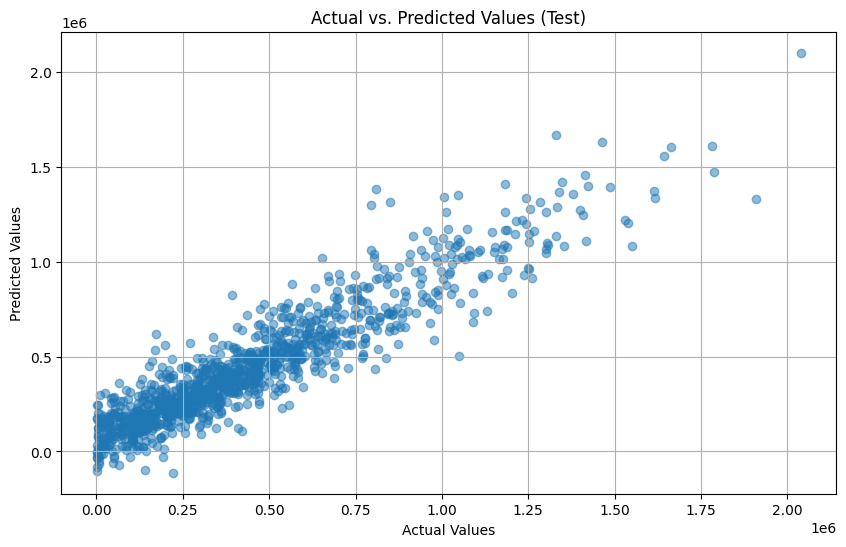

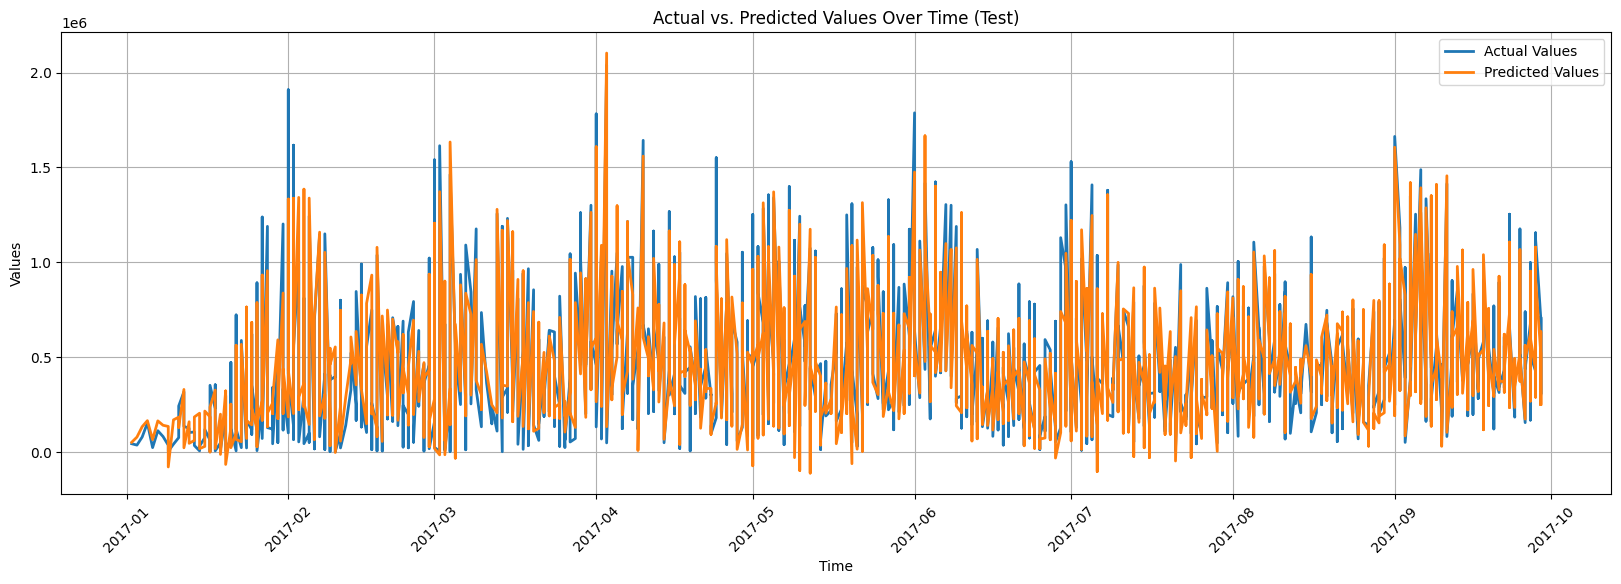

"\n    Given that the test R2 score is relatively close to the average train \n    and validation scores, it appears that the model's performance on the \n    test set is in line with its performance on the training and validation \n    sets. This consistency is a positive sign and suggests that the model \n    has not suffered from significant overfitting or underfitting.\n"

In [46]:
# Make predictions on the test dataset
y_pred_test = KF_linear_model.predict(x_test)

# Calculate Mean Squared Error for the test set
mse_test = mean_squared_error(y_test, y_pred_test)
print('Test Mean Squared Error:', mse_test)

# Calculate Mean Absolute Error for the test set
mae_test = mean_absolute_error(y_test, y_pred_test)
print('Test Mean Absolute Error:', mae_test)

# Calculate R-squared (R2) score for the test set
r2_test = KF_linear_model.score(x_test, y_test)
print('Average Test Score:', r2_test)

# Create a scatter plot for actual vs. predicted values on the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Test)')
plt.grid()
plt.show()

# Sort the data by index for visualization
sorted_y_test = y_test.sort_index()
sorted_y_pred_test = pd.Series(y_pred_test, index=y_test.index)
sorted_y_pred_test = sorted_y_pred_test.sort_index()

# Create a line plot for sorted actual values and sorted predicted values over time
plt.figure(figsize=(20, 6))
plt.plot(sorted_y_test.index, sorted_y_test.values, label='Actual Values', linewidth=2)
plt.plot(sorted_y_test.index, sorted_y_pred_test, label='Predicted Values', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values Over Time (Test)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

"""
    Given that the test R2 score is relatively close to the average train 
    and validation scores, it appears that the model's performance on the 
    test set is in line with its performance on the training and validation 
    sets. This consistency is a positive sign and suggests that the model 
    has not suffered from significant overfitting or underfitting.
"""

In [47]:
# Initialize k-fold cross-validation with 5 splits, shuffling, and a fixed random state
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
mse_scores = []
mae_scores = []
train_scores = []
val_scores = []

# Perform k-fold cross-validation
for train_idx, val_idx in kfold.split(x_kfold):
    # Split the data into training and validation sets based on fold indices
    x_train, x_val = x_kfold.iloc[train_idx], x_kfold.iloc[val_idx]
    y_train, y_val = y_kfold.iloc[train_idx], y_kfold.iloc[val_idx]
    
    # Train an XGBoost regressor on the training data
    KF_xgb_regressor = xgb.XGBRegressor(random_state=42)
    KF_xgb_regressor.fit(x_train, y_train)
    
    # Make predictions on the validation set
    y_pred_val = KF_xgb_regressor.predict(x_val)
    
    # Calculate evaluation metrics for this fold
    mse = mean_squared_error(y_val, y_pred_val)
    mae = mean_absolute_error(y_val, y_pred_val)
    train_score = KF_xgb_regressor.score(x_train, y_train)
    val_score = KF_xgb_regressor.score(x_val, y_val)
    
    # Append metrics to respective lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    train_scores.append(train_score)
    val_scores.append(val_score)

# Calculate and print the average metrics over all folds
avg_mse = sum(mse_scores) / len(mse_scores)
avg_mae = sum(mae_scores) / len(mae_scores)
avg_train_score = sum(train_scores) / len(train_scores)
avg_val_score = sum(val_scores) / len(val_scores)

print('Average MSE:', avg_mse)
print('Average MAE:', avg_mae)
print('Average Train Score:', avg_train_score)
print('Average Validation Score:', avg_val_score)

"""
    The noticeable difference between the average training and 
    validation scores suggests the possibility of overfitting. 
    The model seems to have been trained to fit the training 
    data very closely, which may lead to reduced performance 
    on new data. 
"""

Average MSE: 15999864163.89264
Average MAE: 90984.1222110416
Average Train Score: 0.9823558609539091
Average Validation Score: 0.8457757923757183


'\n    The noticeable difference between the average training and \n    validation scores suggests the possibility of overfitting. \n    The model seems to have been trained to fit the training \n    data very closely, which may lead to reduced performance \n    on new data. \n'

In [48]:
# Initialize time series split
tscv = TimeSeriesSplit(n_splits=2)

# Initialize lists to store metrics
mse_scores = []
mae_scores = []
train_scores = []
val_scores = []

# Perform time series cross-validation
for train_idx, val_idx in tscv.split(x_time):
    # Split the data into training and validation sets based on time series split indices
    x_train, x_val = x_time.iloc[train_idx], x_time.iloc[val_idx]
    y_train, y_val = y_time.iloc[train_idx], y_time.iloc[val_idx]
    
    # Train a linear regression model on the training data
    time_series_reg_model = LinearRegression()
    time_series_reg_model.fit(x_train, y_train)
    
    # Make predictions on the validation set
    y_pred_val = time_series_reg_model.predict(x_val)
    
    # Calculate metrics for evaluation
    mse = mean_squared_error(y_val, y_pred_val)
    mae = mean_absolute_error(y_val, y_pred_val)
    train_score = time_series_reg_model.score(x_train, y_train)
    val_score = time_series_reg_model.score(x_val, y_val)
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    train_scores.append(train_score)
    val_scores.append(val_score)

# Calculate and print the average metrics over all folds
avg_mse = sum(mse_scores) / len(mse_scores)
avg_mae = sum(mae_scores) / len(mae_scores)
avg_train_score = sum(train_scores) / len(train_scores)
avg_val_score = sum(val_scores) / len(val_scores)

print('Average MSE:', avg_mse)
print('Average MAE:', avg_mae)
print('Average Train Score:', avg_train_score)
print('Average Validation Score:', avg_val_score)


Average MSE: 10988263513.724388
Average MAE: 78113.71134427706
Average Train Score: 0.9298346830527402
Average Validation Score: 0.8844765704366879


Test Mean Squared Error: 17617601221.333035
Test Mean Absolute Error: 98784.0190328469
Test Score: 0.845547256899316


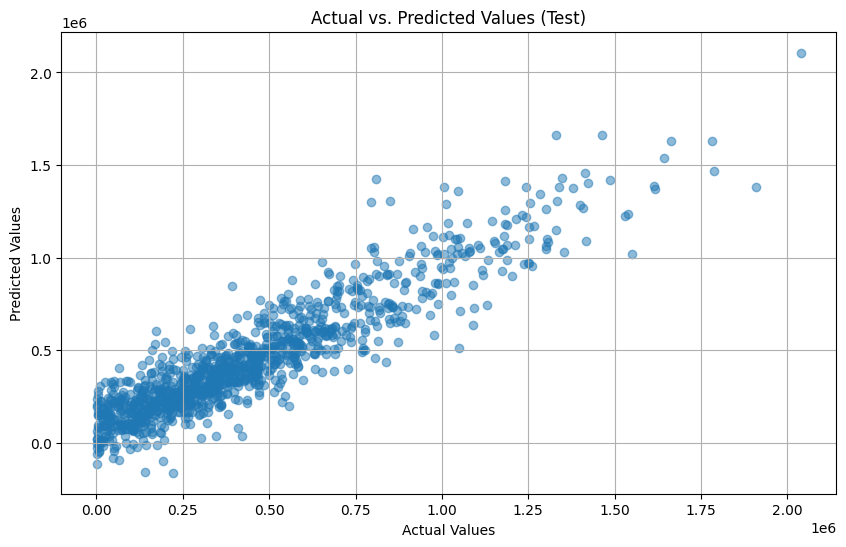

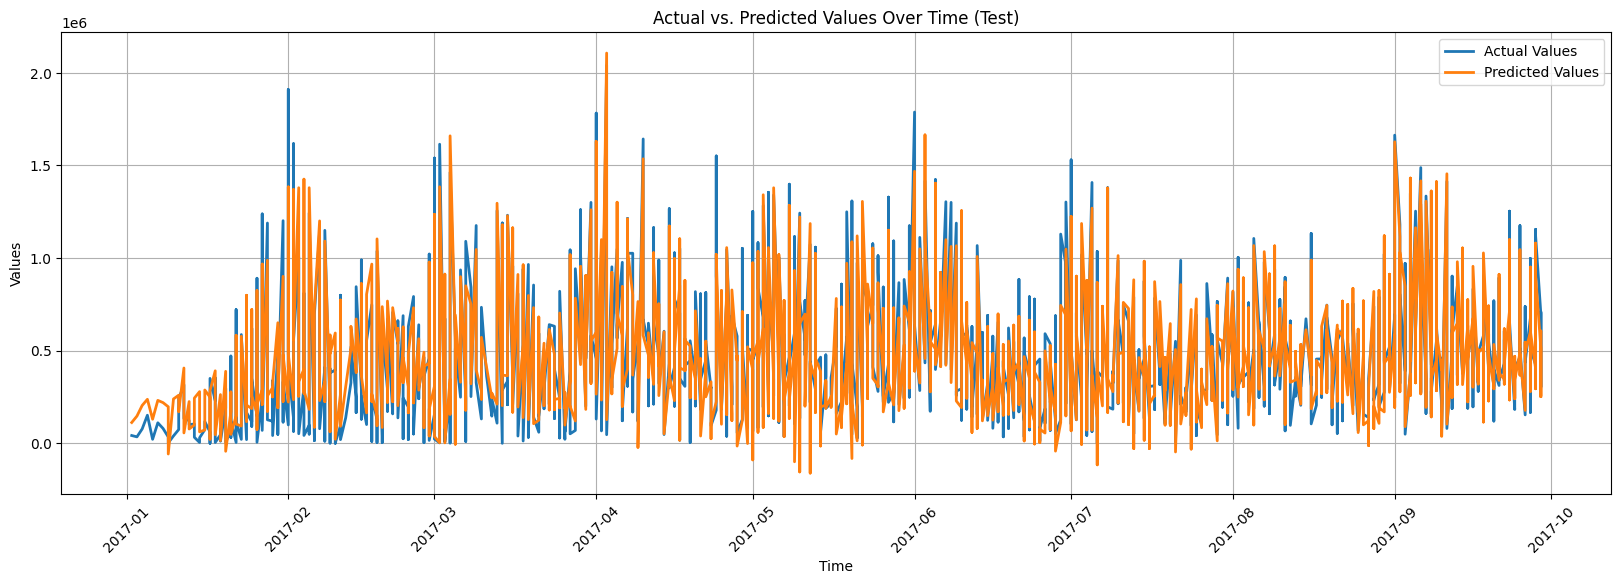

"\n    Given that the test R2 score is relatively close to the average train \n    and validation scores, it appears that the model's performance on the \n    test set is in line with its performance on the training and validation \n    sets. This consistency is a positive sign and suggests that the model \n    has not suffered from significant overfitting or underfitting.\n"

In [49]:
# Train the time series model on the entire training data (x_train, y_train)
time_series_reg_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred_test = time_series_reg_model.predict(x_test)

# Calculate Mean Squared Error for the test set
mse_test = mean_squared_error(y_test, y_pred_test)
print('Test Mean Squared Error:', mse_test)

# Calculate Mean Absolute Error for the test set
mae_test = mean_absolute_error(y_test, y_pred_test)
print('Test Mean Absolute Error:', mae_test)

# Calculate R-squared (R2) score for the test set
r2_test = time_series_reg_model.score(x_test, y_test)
print('Average Test Score:', r2_test)

# Create a scatter plot for actual vs. predicted values on the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Test)')
plt.grid()
plt.show()

# Sort the data by index for visualization
sorted_y_test = y_test.sort_index()
sorted_y_pred_test = pd.Series(y_pred_test, index=y_test.index)
sorted_y_pred_test = sorted_y_pred_test.sort_index()

# Create a line plot for sorted actual values and sorted predicted values over time
plt.figure(figsize=(20, 6))
plt.plot(sorted_y_test.index, sorted_y_test.values, label='Actual Values', linewidth=2)
plt.plot(sorted_y_test.index, sorted_y_pred_test, label='Predicted Values', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values Over Time (Test)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

"""
    Given that the test R2 score is relatively close to the average train 
    and validation scores, it appears that the model's performance on the 
    test set is in line with its performance on the training and validation 
    sets. This consistency is a positive sign and suggests that the model 
    has not suffered from significant overfitting or underfitting. But,
    due to the difference between the average training and test scores
    which is not very small, the model might slighlty overfitting.
"""


In [50]:
# Initialize time series split with 2 splits
time_series_splitter = TimeSeriesSplit(n_splits=2)

# Initialize lists to store evaluation metrics
mse_scores = []
mae_scores = []
train_scores = []
val_scores = []

# Perform time series cross-validation
for train_idx, val_idx in time_series_splitter.split(x_time):
    # Split the data into training and validation sets based on fold indices
    x_train, x_val = x_time.iloc[train_idx], x_time.iloc[val_idx]
    y_train, y_val = y_time.iloc[train_idx], y_time.iloc[val_idx]
    
    # Initialize and train an XGBoost regressor
    xgb_time_split_model = xgb.XGBRegressor(random_state=42)
    xgb_time_split_model.fit(x_train, y_train)
    
    # Make predictions on the validation set
    y_pred_val = xgb_time_split_model.predict(x_val)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_val, y_pred_val)
    mae = mean_absolute_error(y_val, y_pred_val)
    train_score = xgb_time_split_model.score(x_train, y_train)
    val_score = xgb_time_split_model.score(x_val, y_val)
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    train_scores.append(train_score)
    val_scores.append(val_score)

# Calculate and print the average metrics over all folds
avg_mse = sum(mse_scores) / len(mse_scores)
avg_mae = sum(mae_scores) / len(mae_scores)
avg_train_score = sum(train_scores) / len(train_scores)
avg_val_score = sum(val_scores) / len(val_scores)

print('Average MSE:', avg_mse)
print('Average MAE:', avg_mae)
print('Average Train Score:', avg_train_score)
print('Average Validation Score:', avg_val_score)

"""
    These results indicate a significant risk of overfitting, as evidenced by the 
    substantial gap between the train and validation scores. The model seems to be 
    fitting the training data almost perfectly but struggles to generalize well to 
    unseen data, which is reflected in the lower validation score
"""

Average MSE: 23849280622.69371
Average MAE: 109880.80512887704
Average Train Score: 0.9916335618745913
Average Validation Score: 0.7697123973217146


'\n    These results indicate a significant risk of overfitting, as evidenced by the \n    substantial gap between the train and validation scores. The model seems to be \n    fitting the training data almost perfectly but struggles to generalize well to \n    unseen data, which is reflected in the lower validation score\n'